<a href="https://colab.research.google.com/github/mariagrincon/HappyHalt/blob/main/Garcia_Filters_Feature_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import models, transforms
import requests
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#define alexnet model
alexnet = models.alexnet(pretrained=True).to(device)
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

#transform image for use in model
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

#load the image from its url
url = 'https://www.wklaw.com/wp-content/uploads/2015/03/red-light.jpg'
img = Image.open(requests.get(url, stream=True).raw)

In [3]:
img_t = preprocess(img).unsqueeze_(0).to(device)

In [4]:
img_t.shape

torch.Size([1, 3, 224, 224])

In [5]:
labels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [6]:
#classify the image with alexnet
scores, class_idx = alexnet(img_t).max(1)
print('Predicted class:', labels[class_idx.item()])

Predicted class: traffic light, traffic signal, stoplight


In [7]:
w0 = alexnet.features[0].weight.data
w1 = alexnet.features[3].weight.data
w2 = alexnet.features[6].weight.data
w3 = alexnet.features[8].weight.data
w4 = alexnet.features[10].weight.data
w5 = alexnet.classifier[1].weight.data
w6 = alexnet.classifier[4].weight.data
w7 = alexnet.classifier[6].weight.data

In [8]:
# Save and Load
# w = [w0,w1,w2,w3,w4,w5,w6,w7]
# torch.save(w, 'Hahn_Alex.pt')
# w = torch.load('Hahn_Alex.pt')
# [w0,w1,w2,w3,w4,w5,w6,w7] = w
# [w0,w1,w2,w3,w4,w5,w6,w7] = torch.load('Hahn_Alex.pt')

In [9]:
img_t.shape,w0.shape

(torch.Size([1, 3, 224, 224]), torch.Size([64, 3, 11, 11]))

In [10]:
img_t.shape

torch.Size([1, 3, 224, 224])

In [11]:
img_t[0,:,:,:].shape

torch.Size([3, 224, 224])

In [12]:
def scale(img):
    # Normalize the NumPy array to the range [0, 1]
    max_value = img.max()
    min_value = img.min()
    normalized_array = (img - min_value) / (max_value - min_value)
    return normalized_array

In [13]:
def tensor_plot(img_t,index=0):
    numpy_array = img_t[index,:,:,:].cpu().numpy()
    numpy_array_transposed = numpy_array.transpose(1, 2, 0)
    numpy_array_transposed = scale(numpy_array_transposed)
    plt.imshow(numpy_array_transposed)
    plt.show()

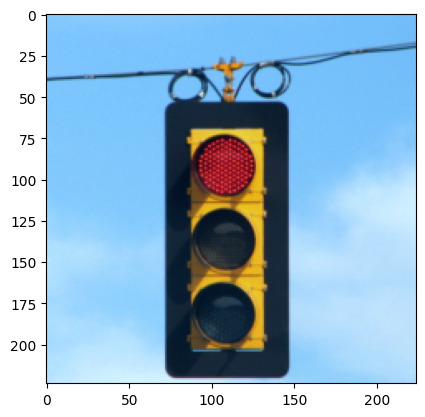

In [14]:
tensor_plot(img_t)

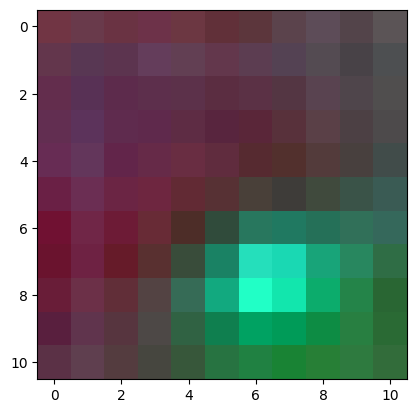

In [15]:
tensor_plot(w0,0)

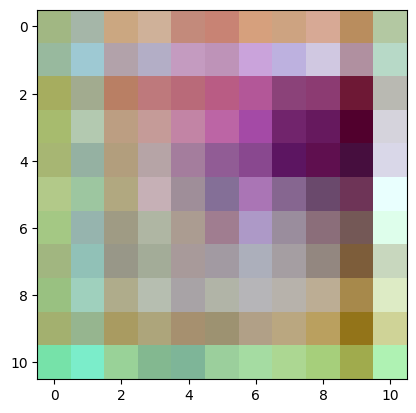

In [16]:
tensor_plot(w0,1)

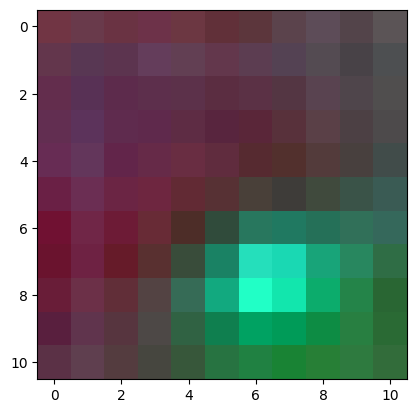

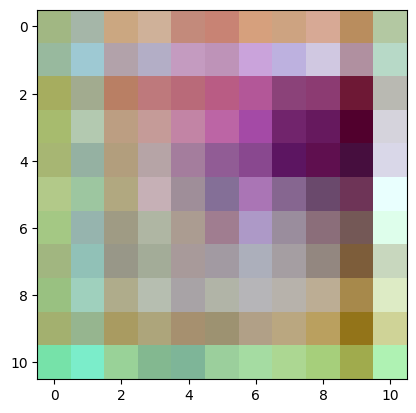

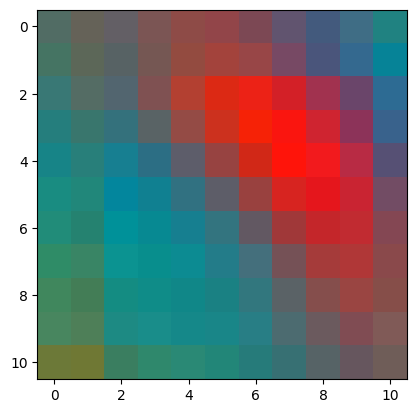

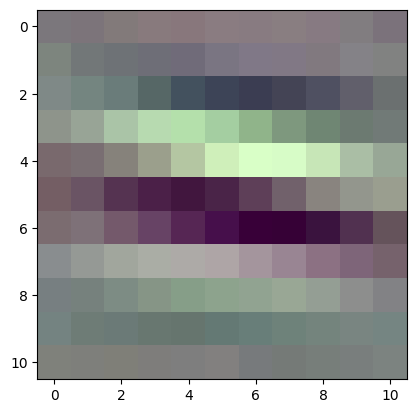

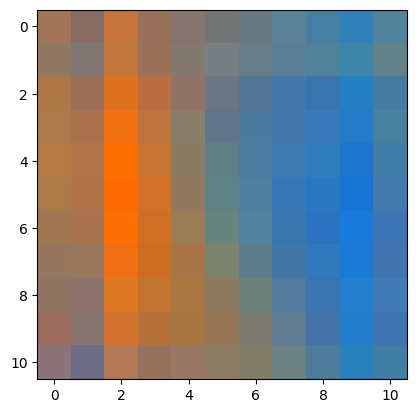

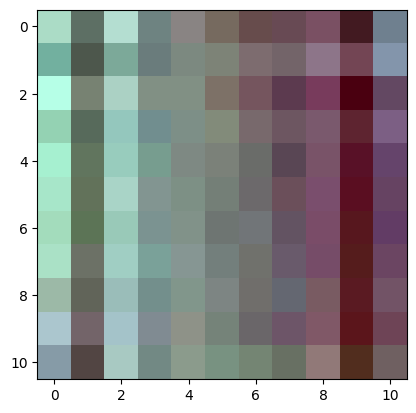

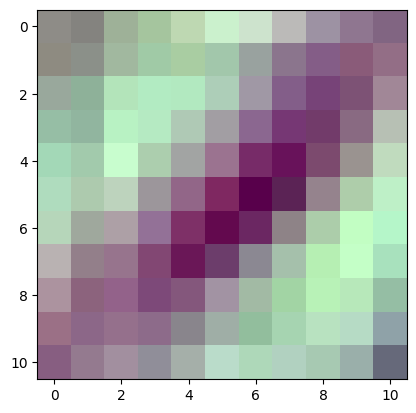

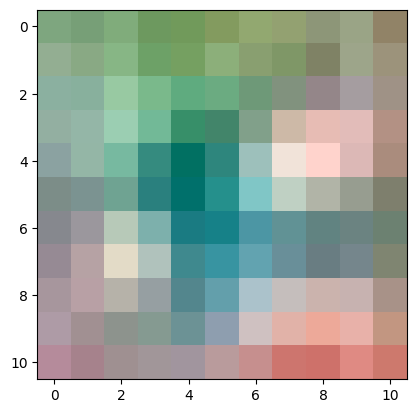

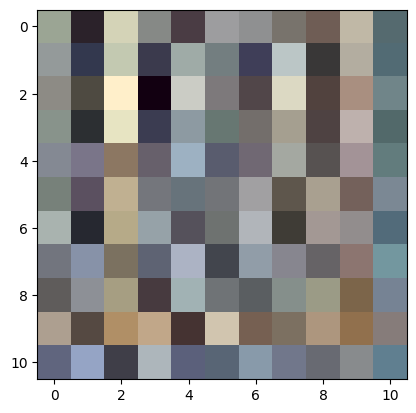

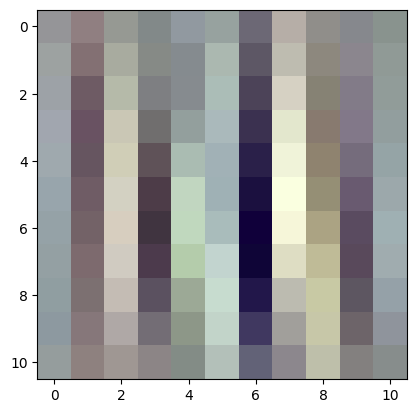

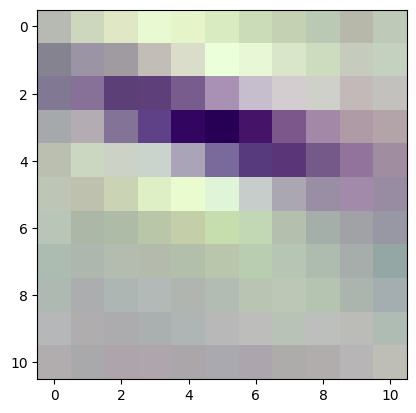

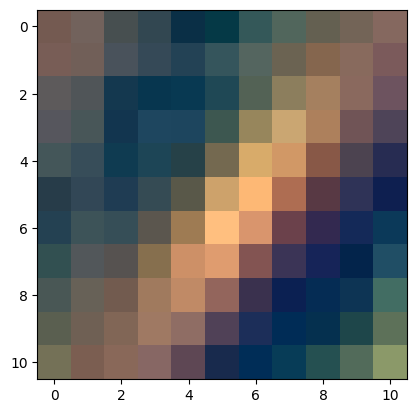

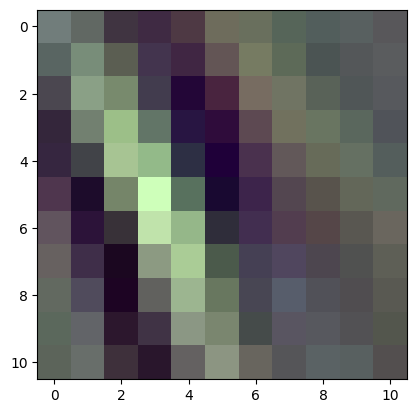

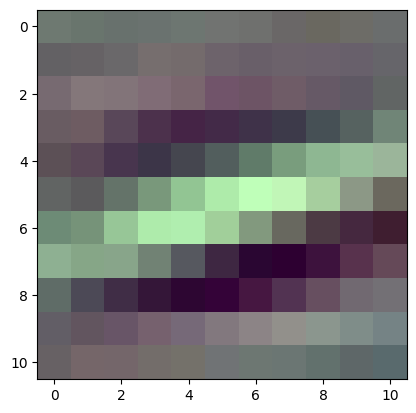

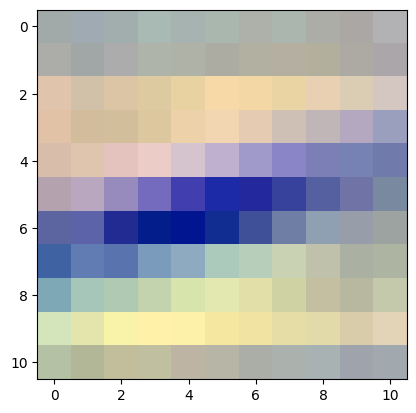

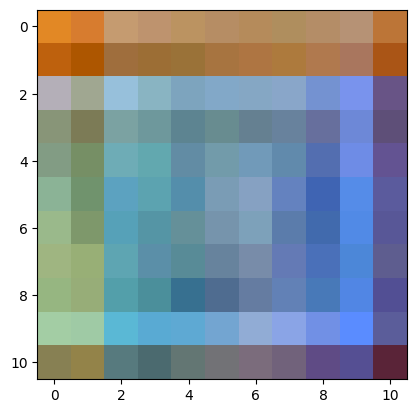

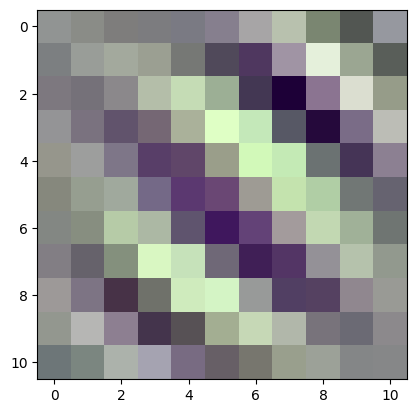

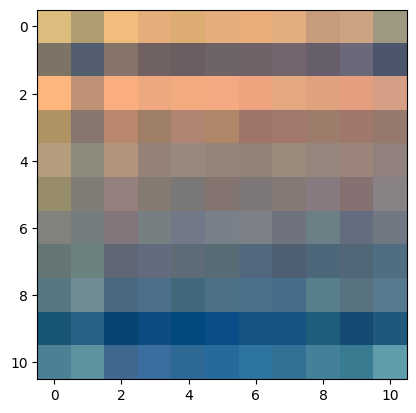

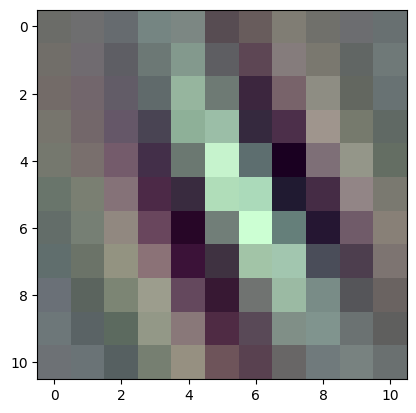

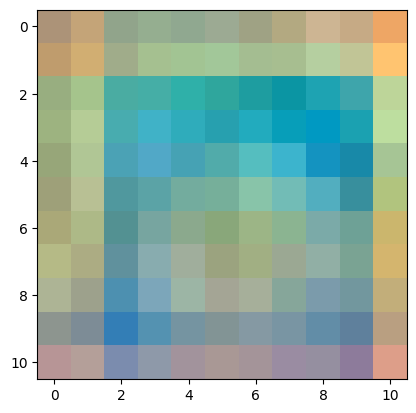

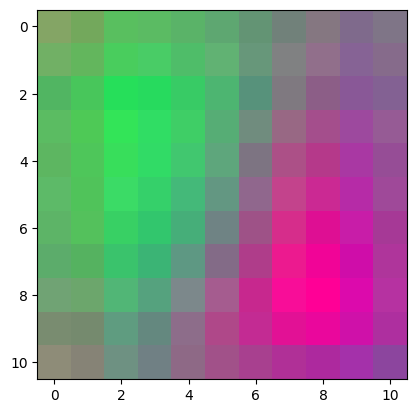

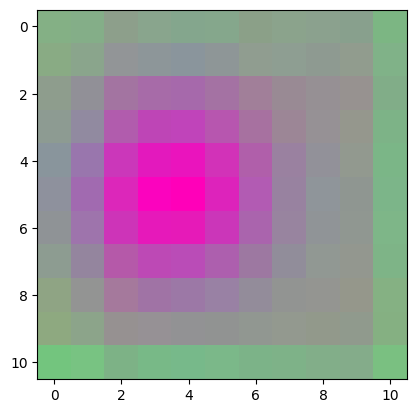

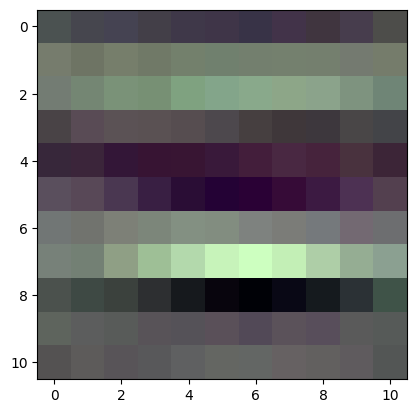

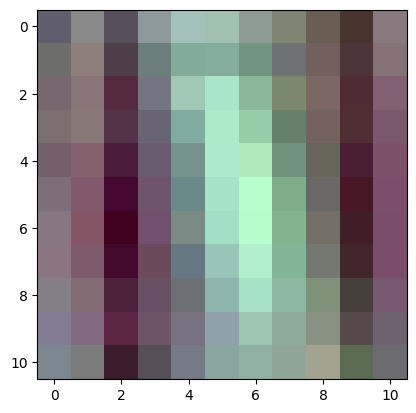

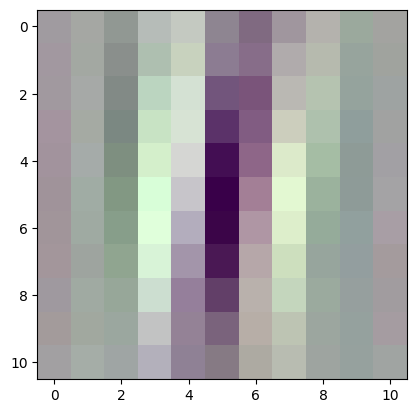

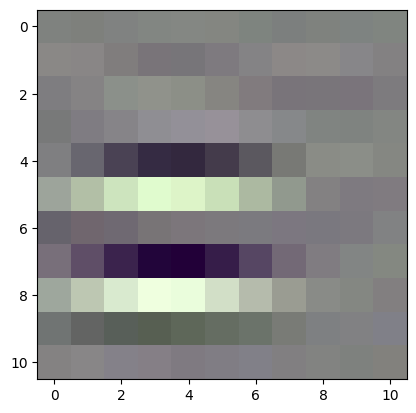

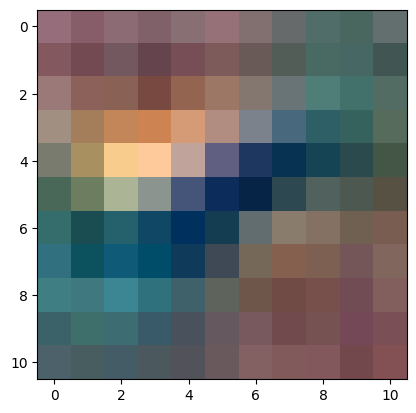

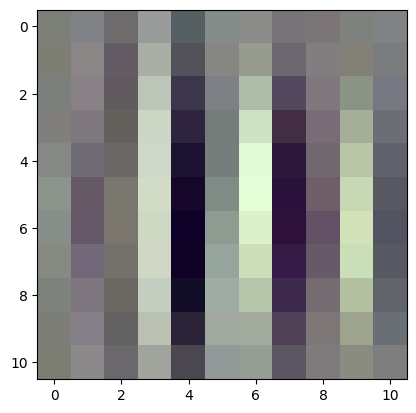

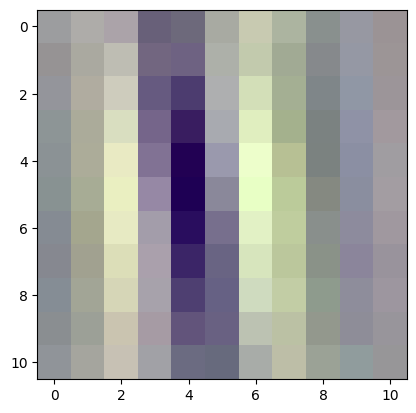

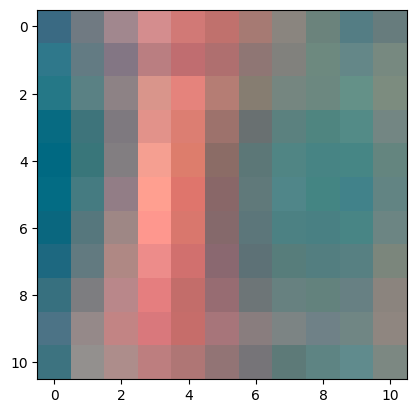

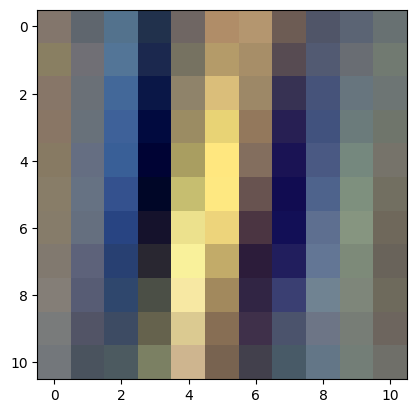

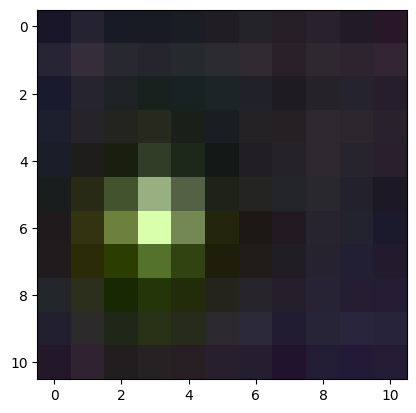

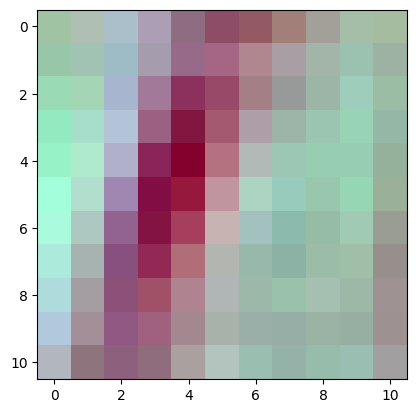

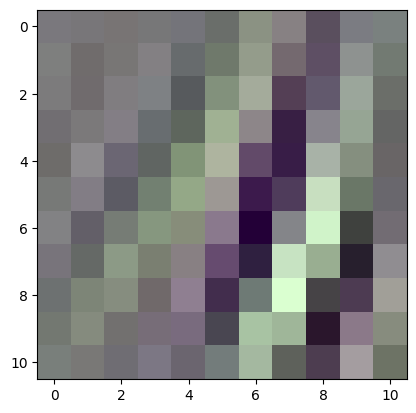

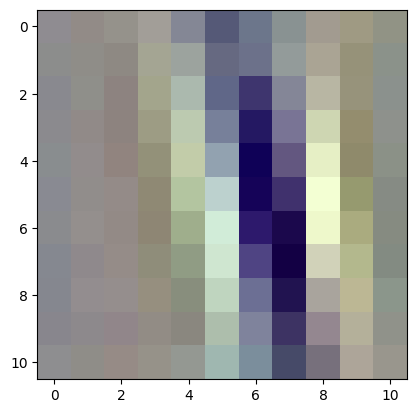

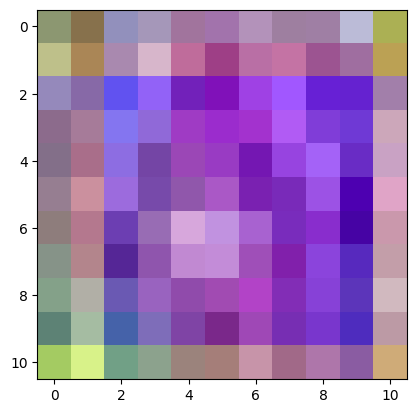

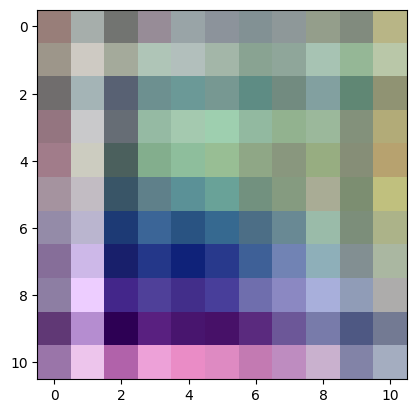

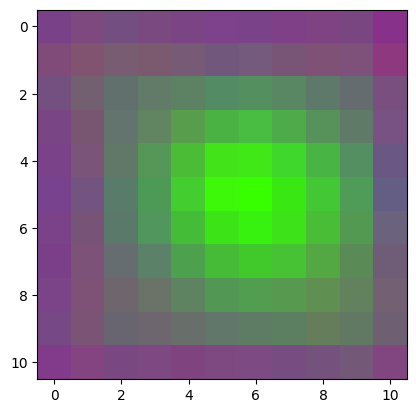

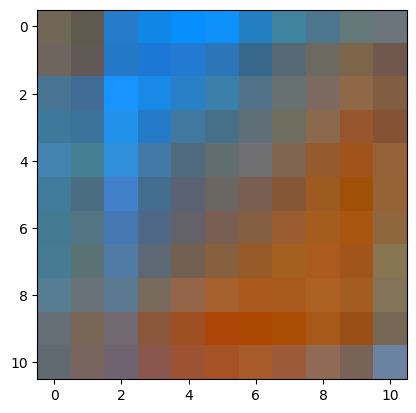

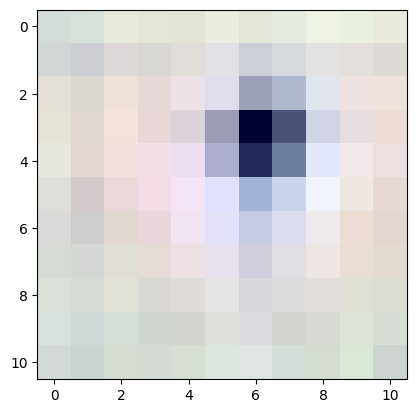

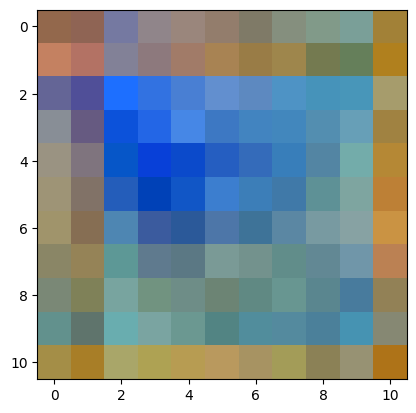

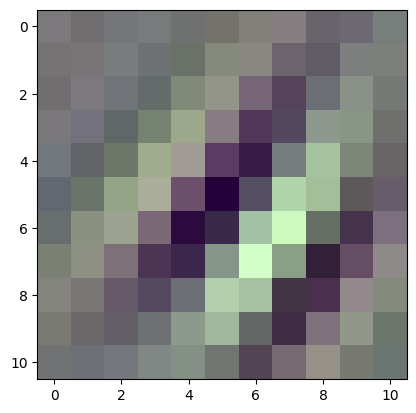

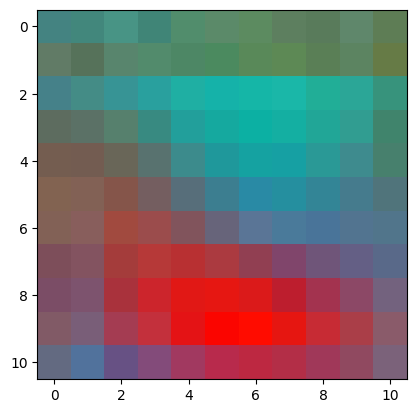

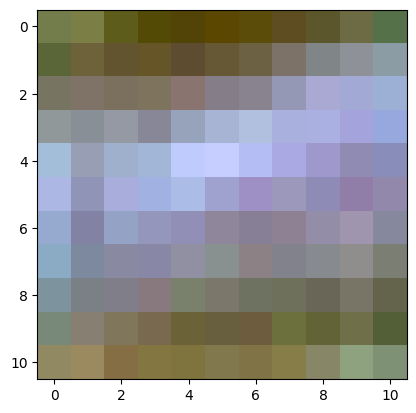

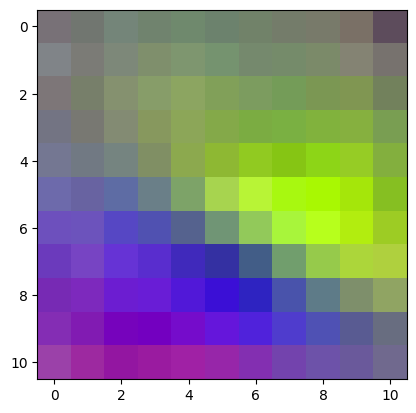

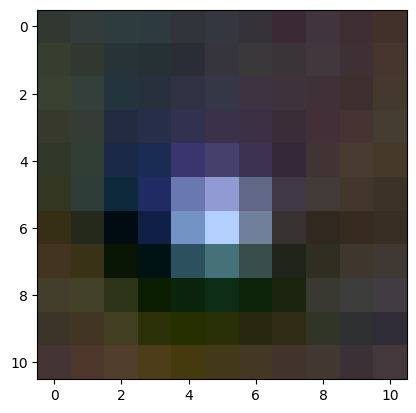

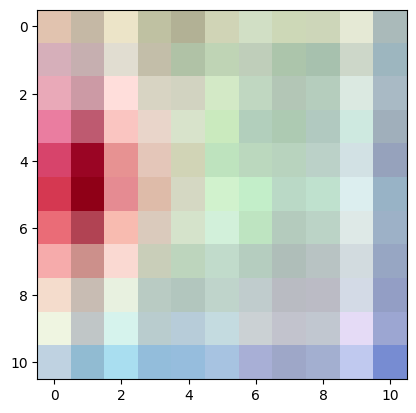

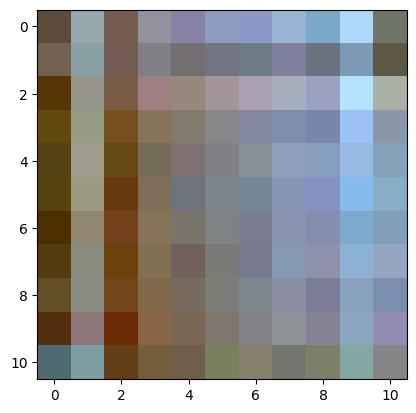

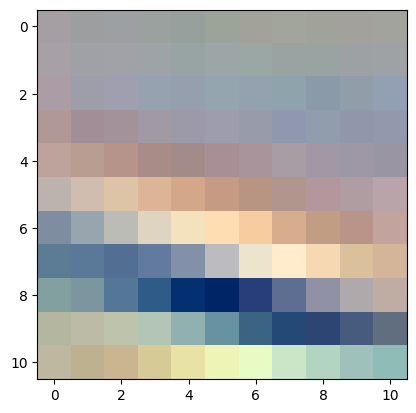

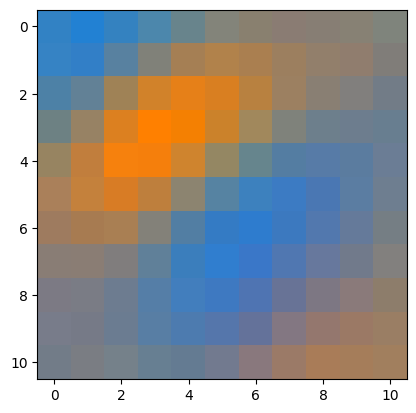

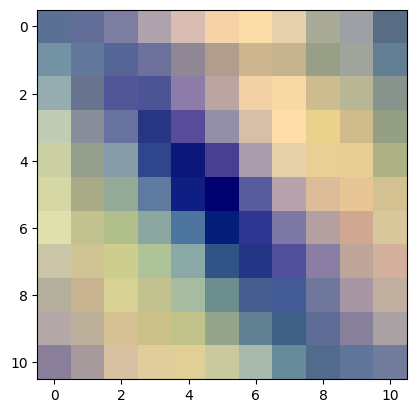

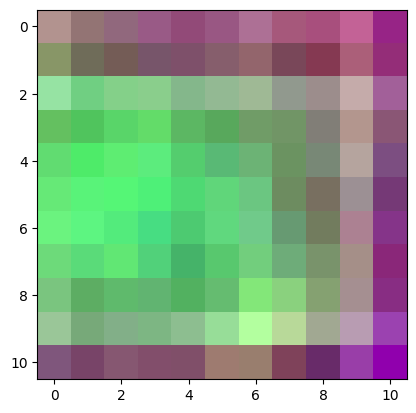

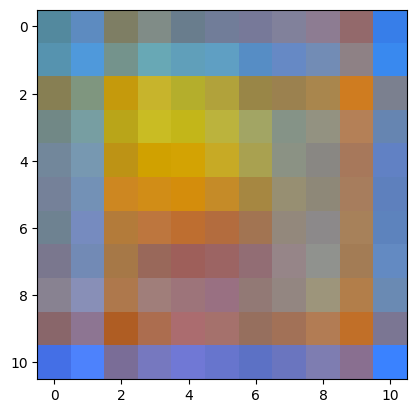

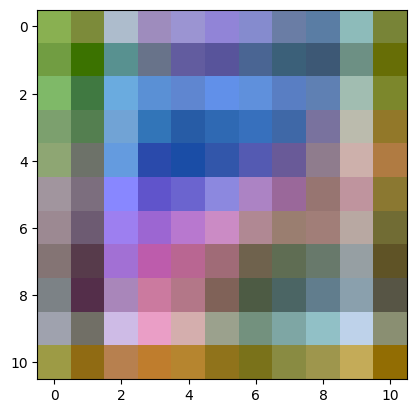

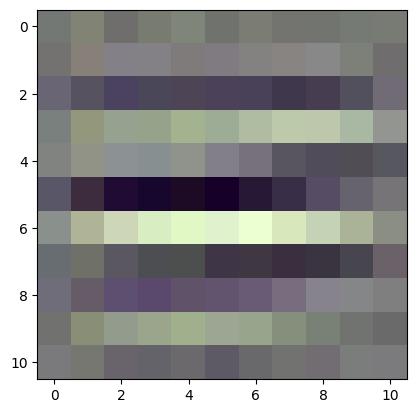

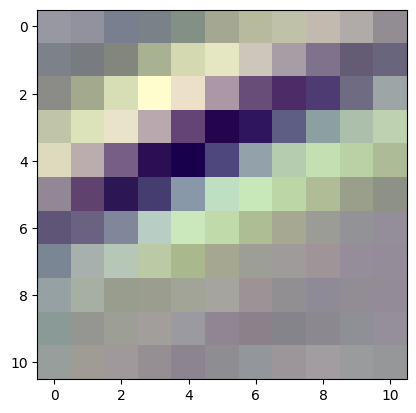

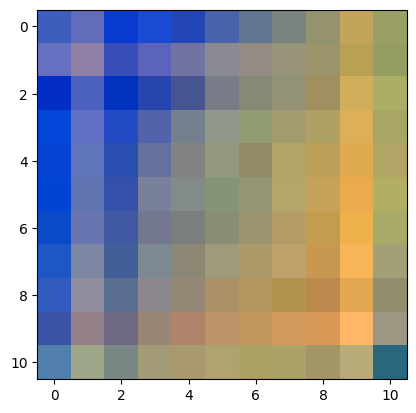

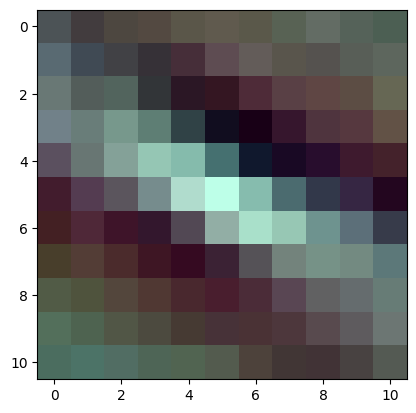

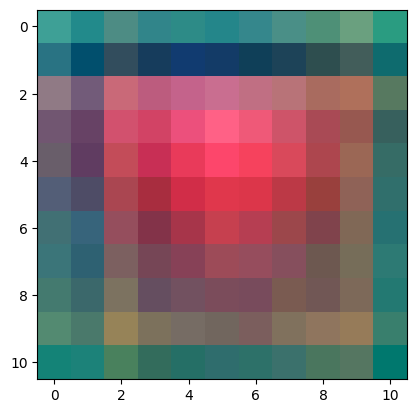

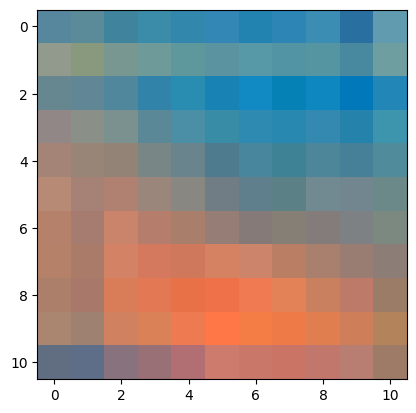

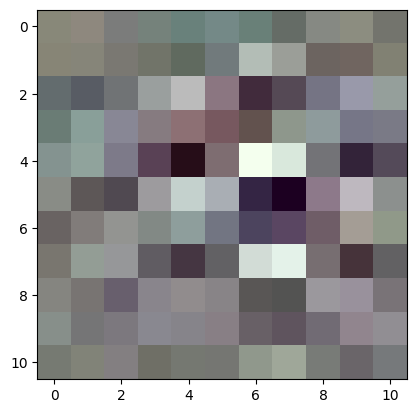

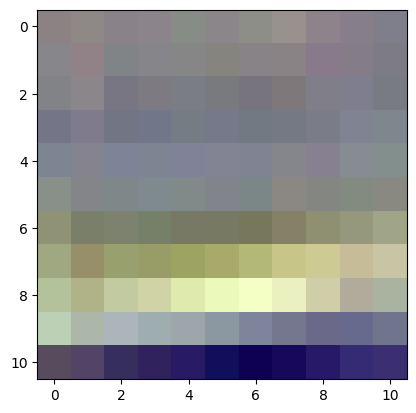

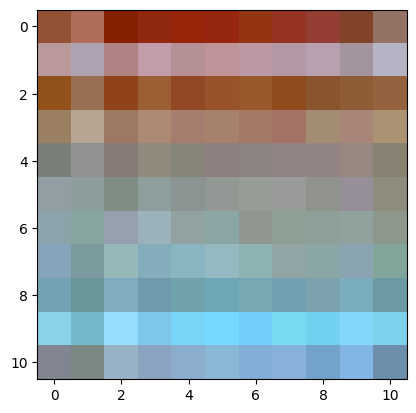

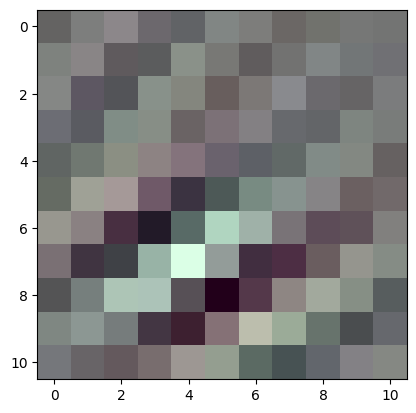

In [17]:
for i in range(64):
    tensor_plot(w0,i)

In [18]:
w0.shape

torch.Size([64, 3, 11, 11])

In [19]:
f0 = F.conv2d(img_t, w0, stride=4, padding=2)

In [20]:
f0.shape

torch.Size([1, 64, 55, 55])

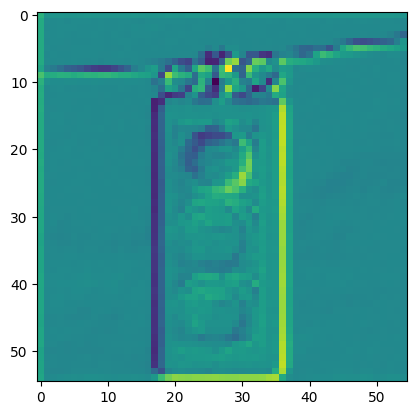

In [21]:
i = 0
plt.imshow(f0[0,i,:,:].cpu().numpy())

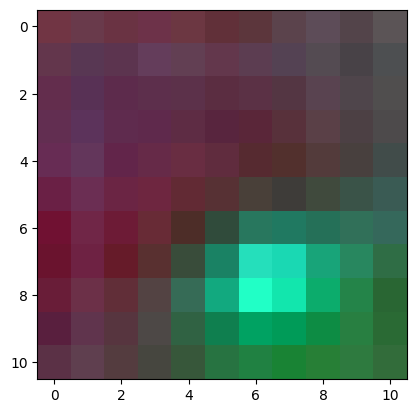

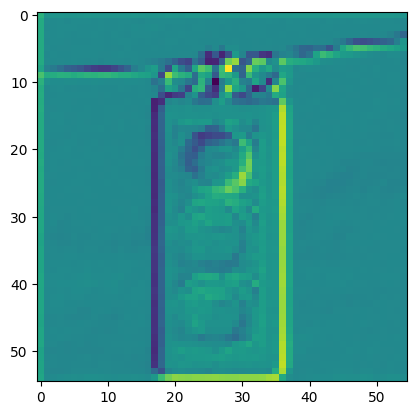

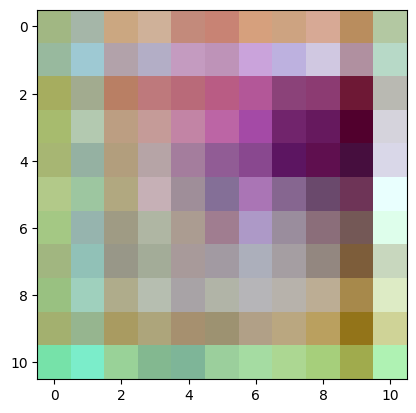

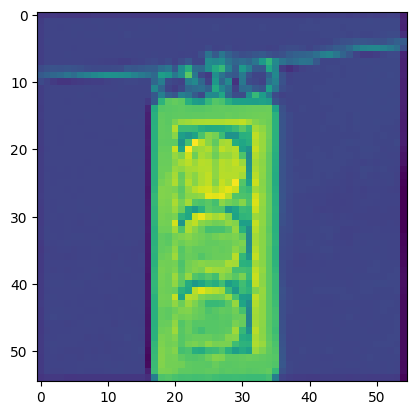

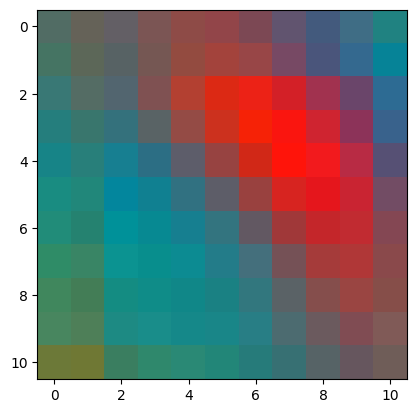

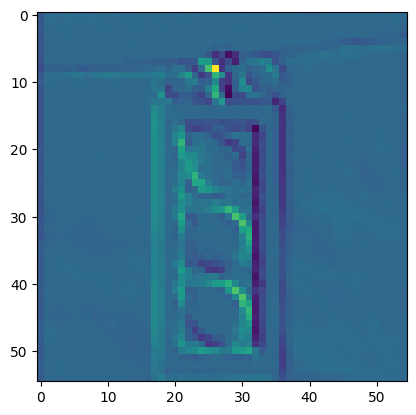

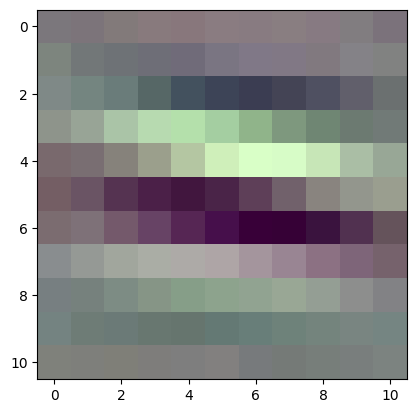

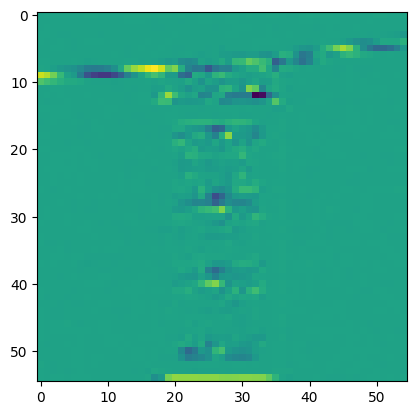

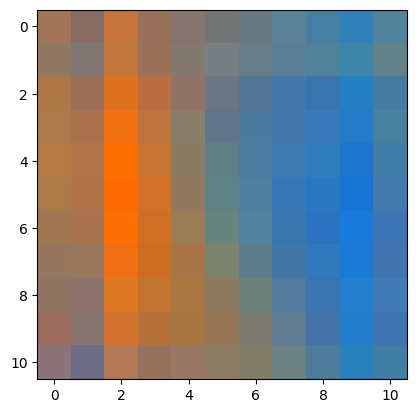

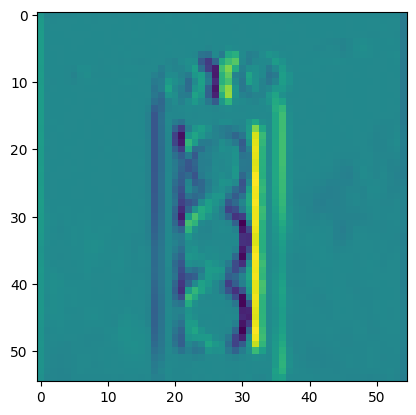

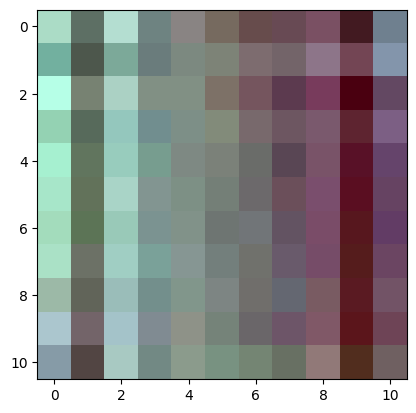

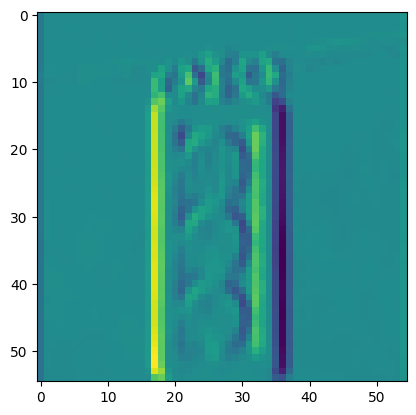

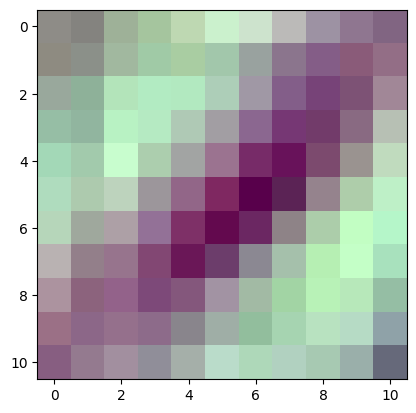

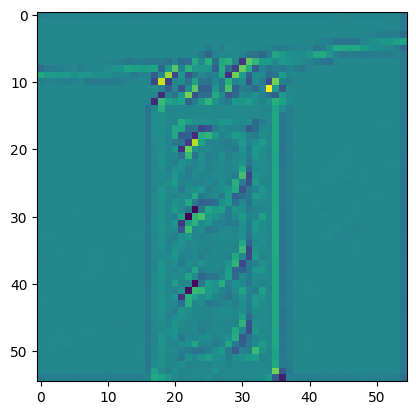

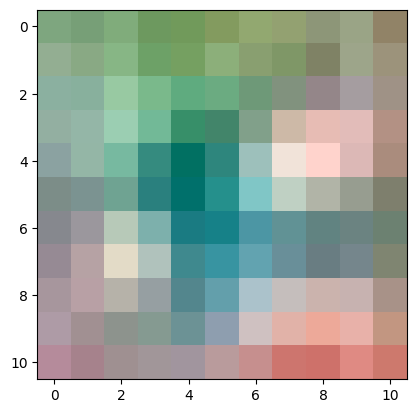

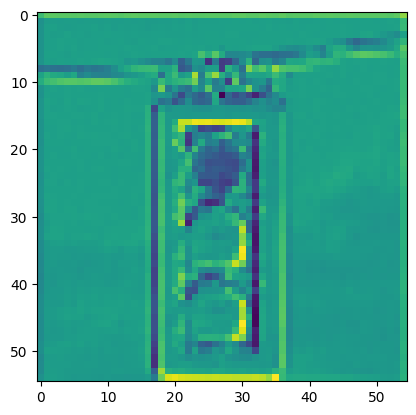

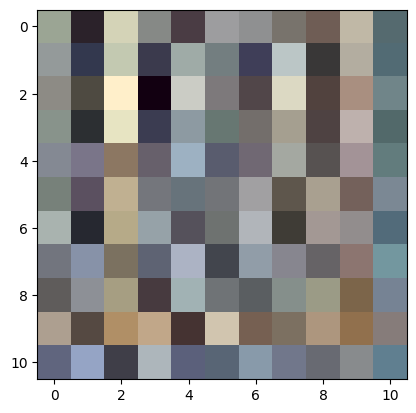

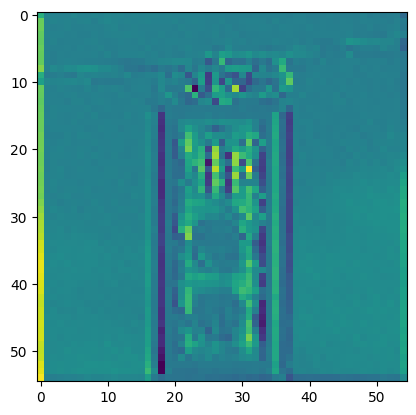

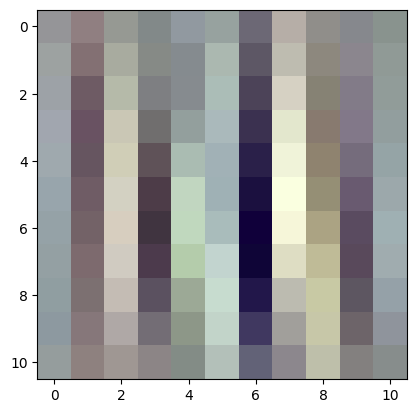

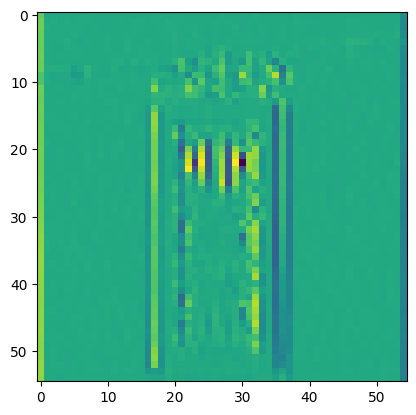

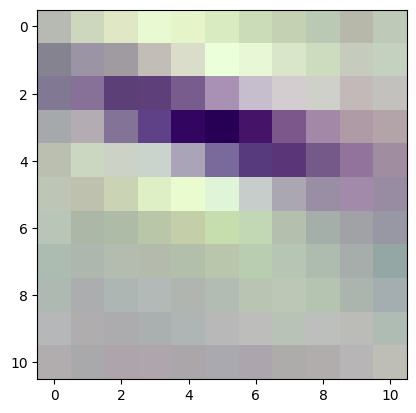

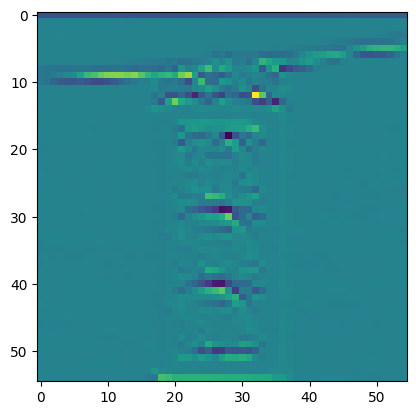

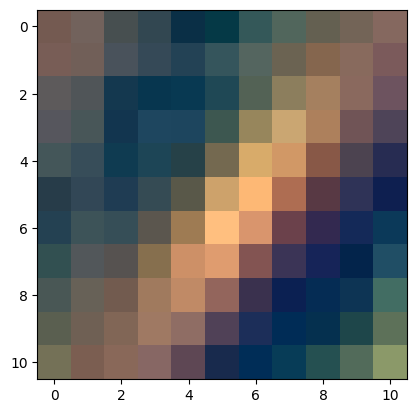

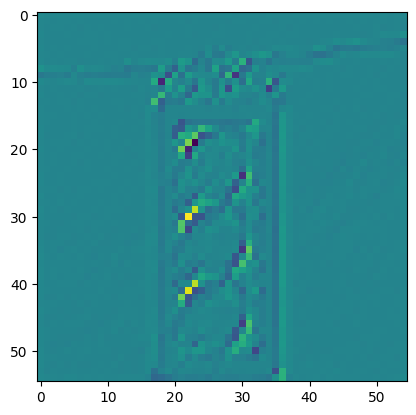

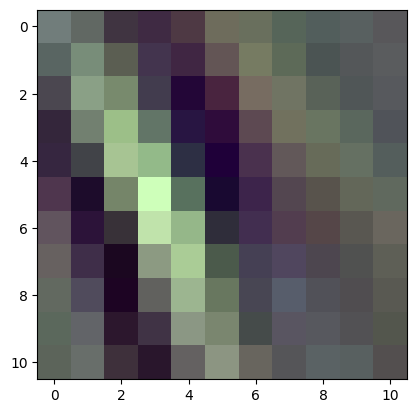

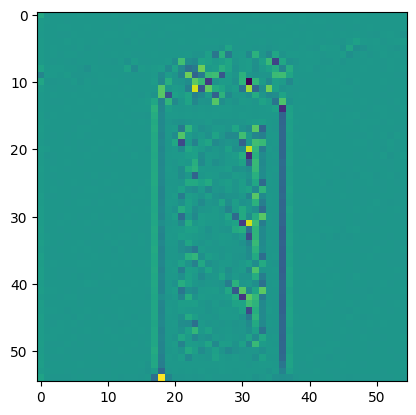

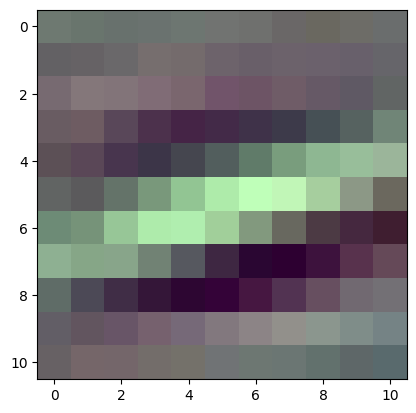

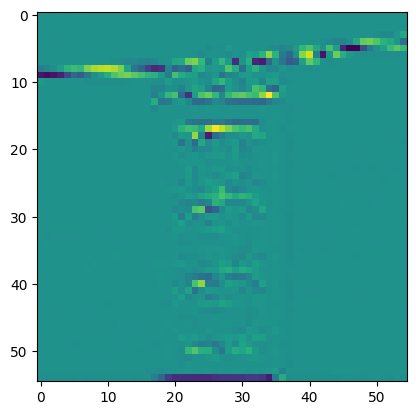

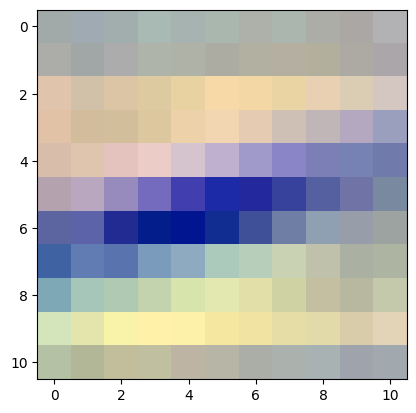

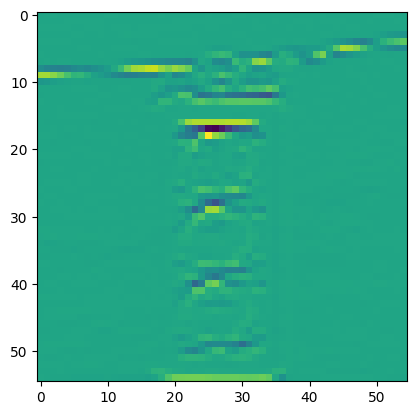

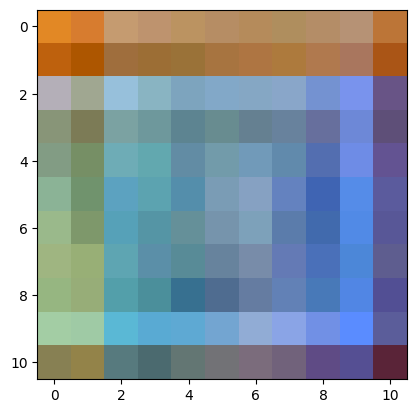

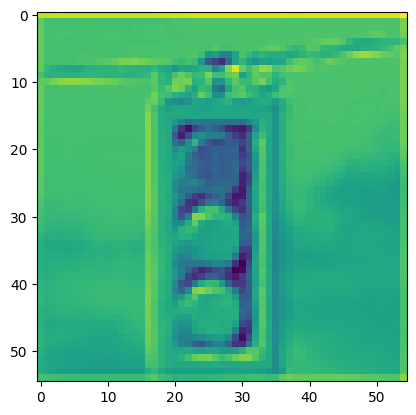

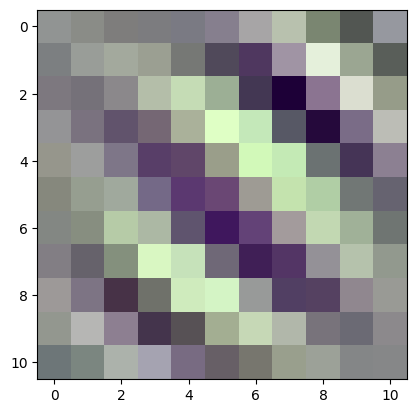

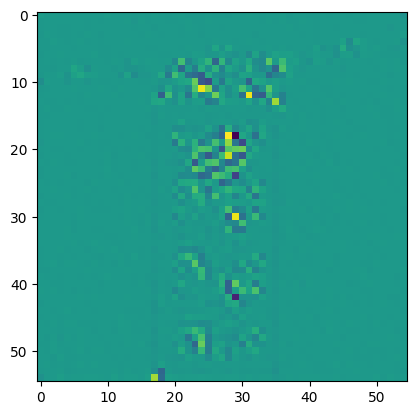

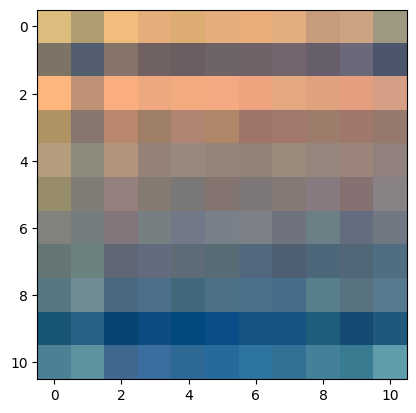

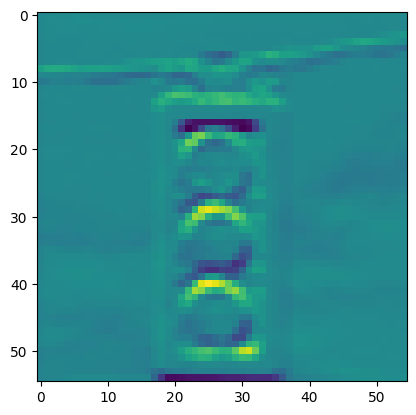

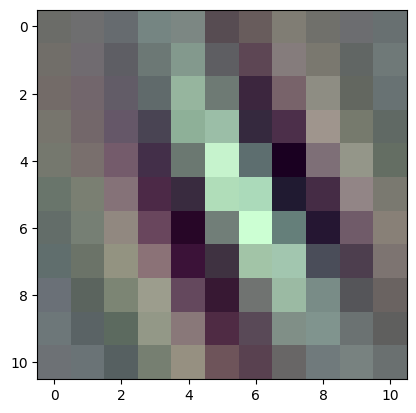

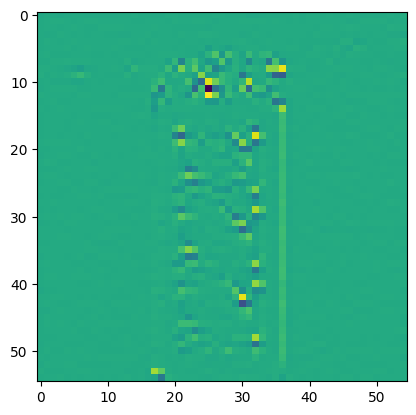

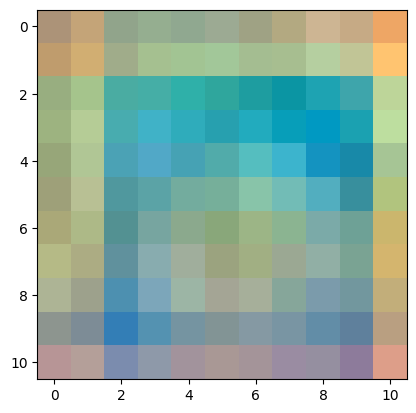

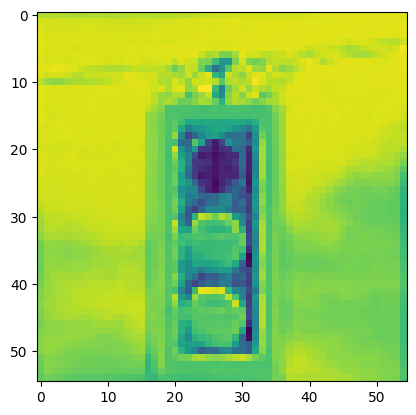

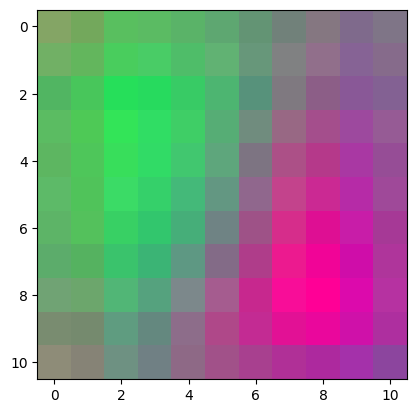

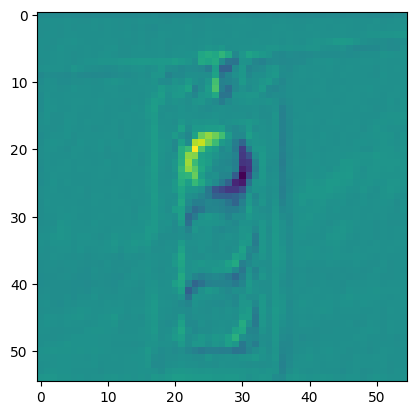

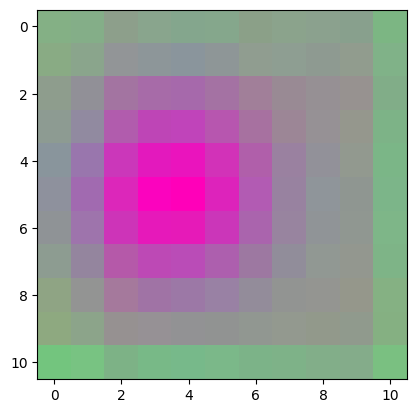

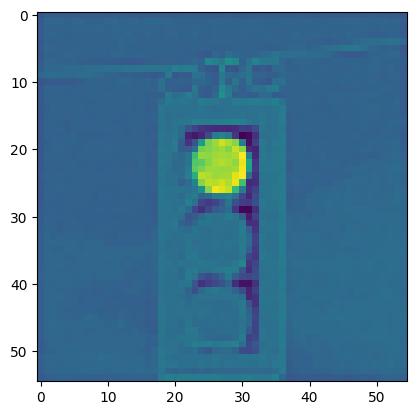

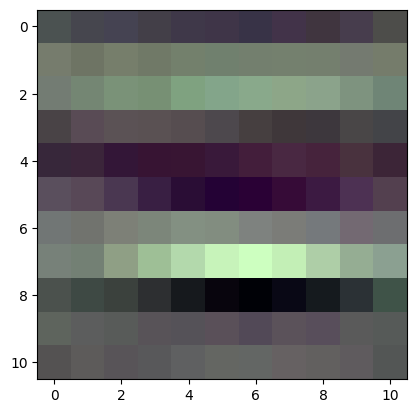

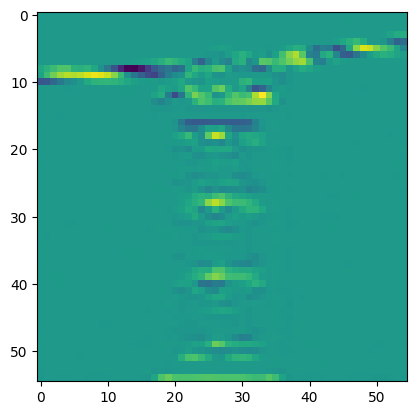

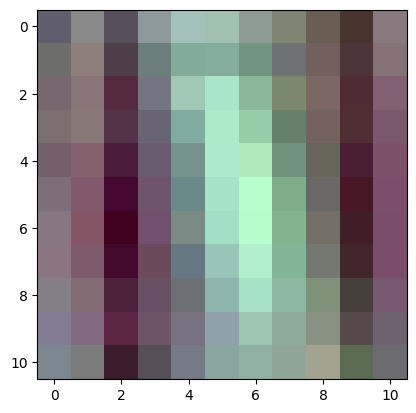

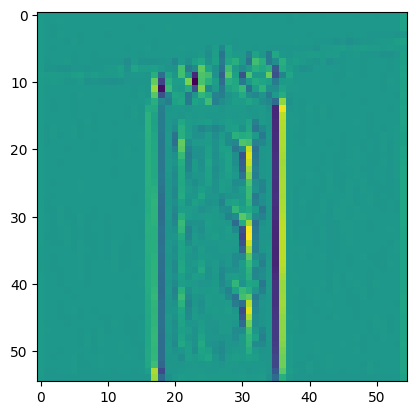

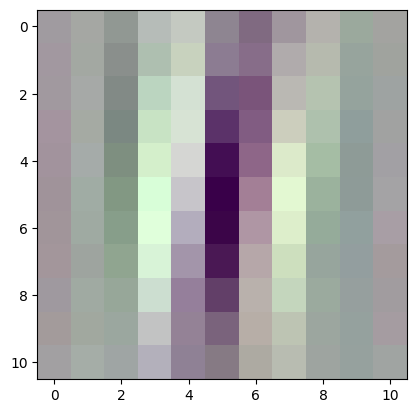

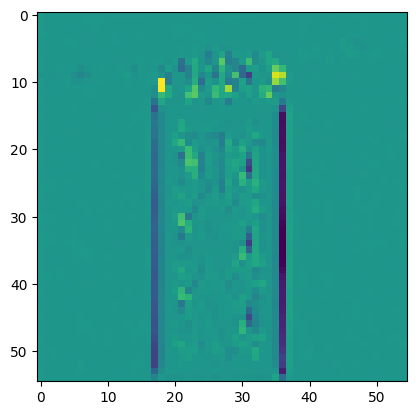

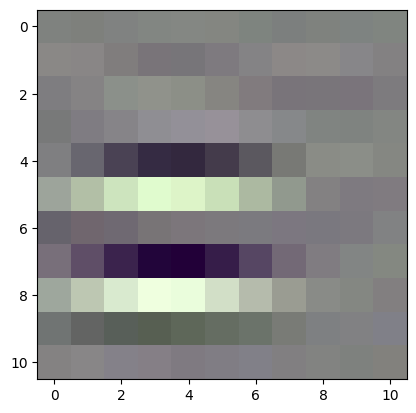

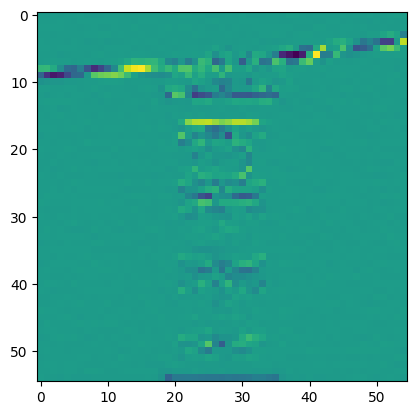

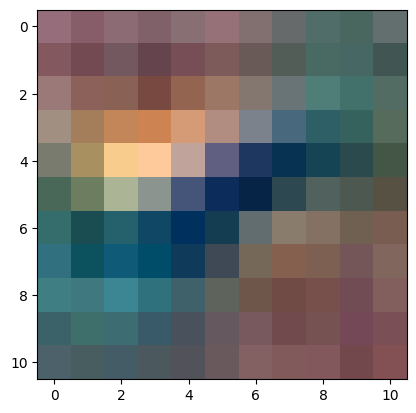

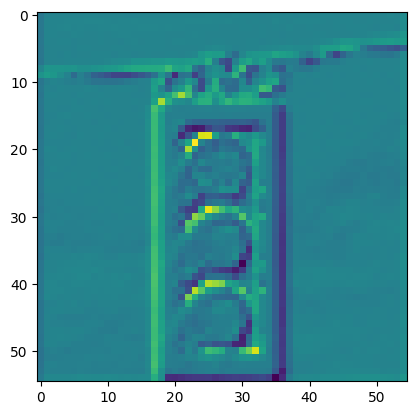

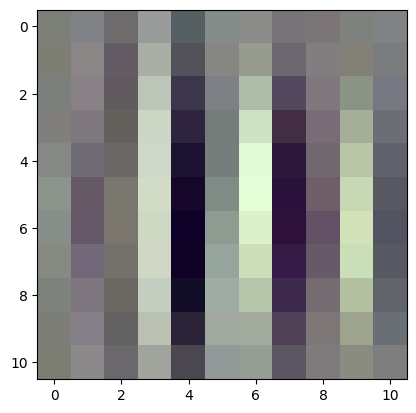

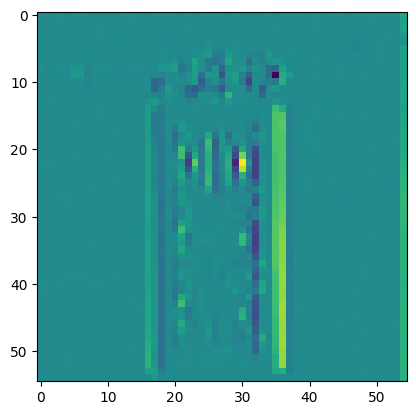

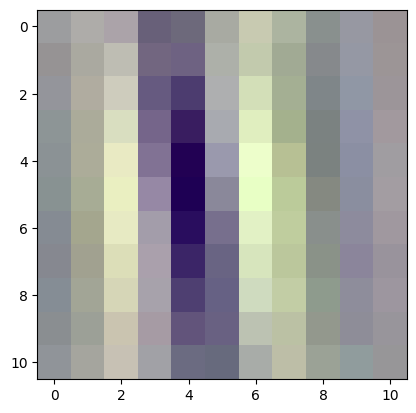

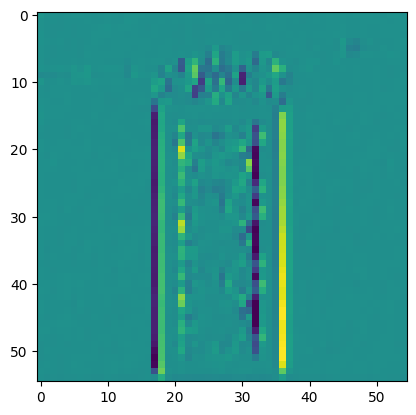

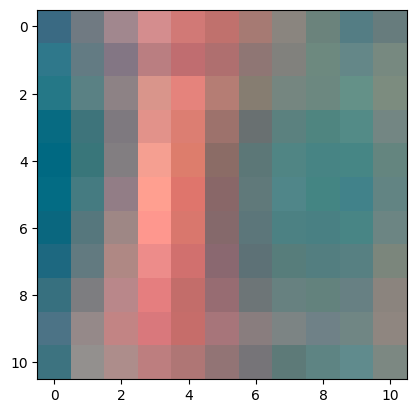

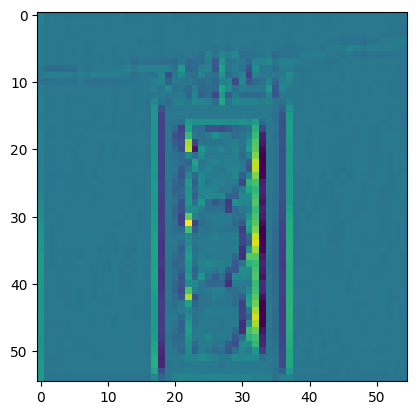

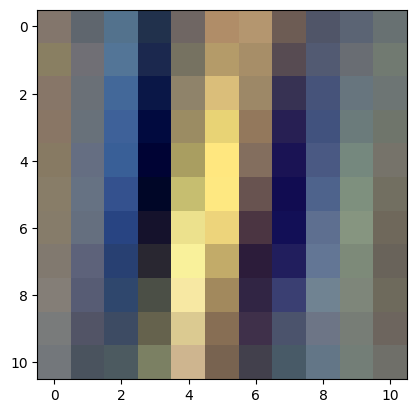

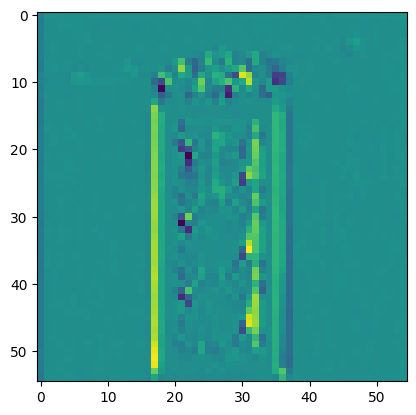

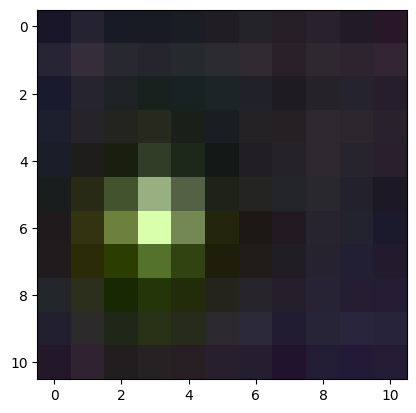

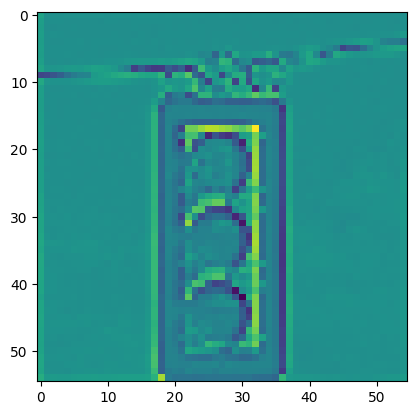

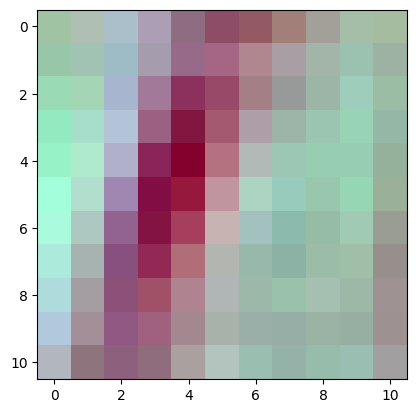

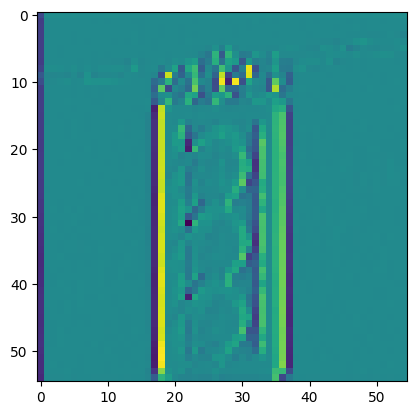

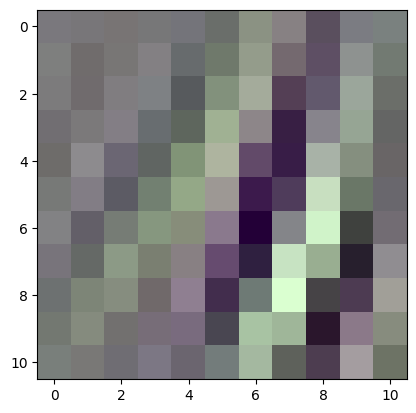

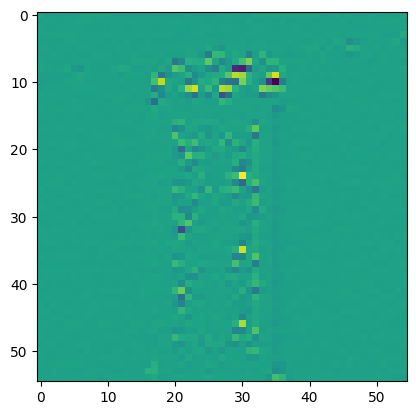

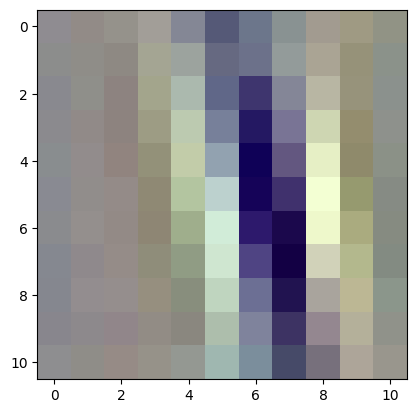

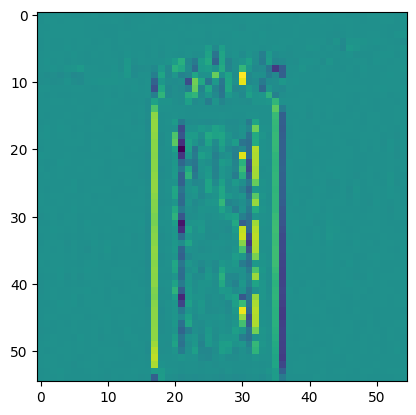

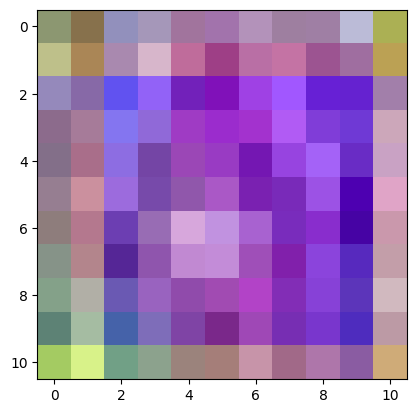

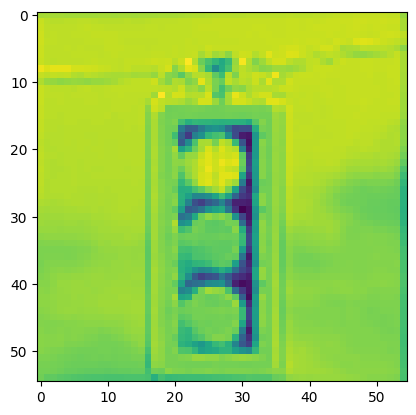

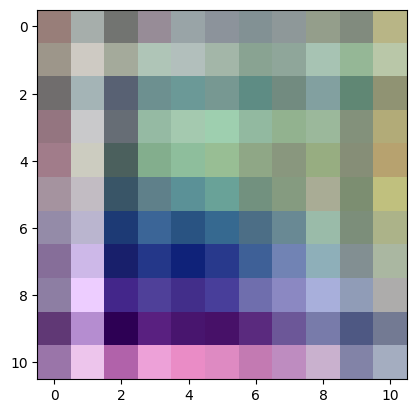

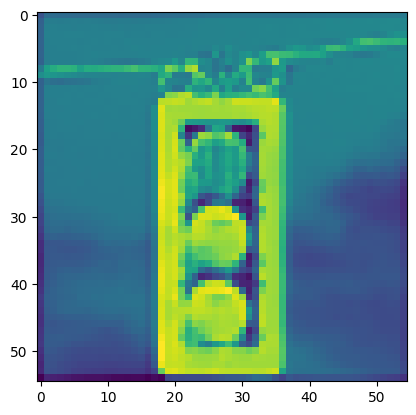

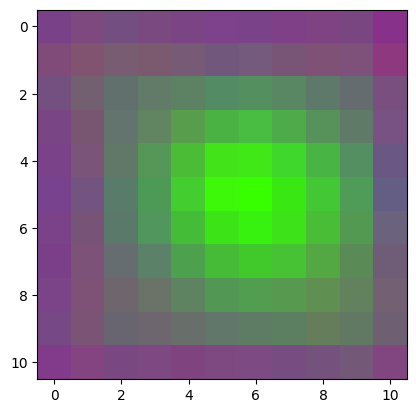

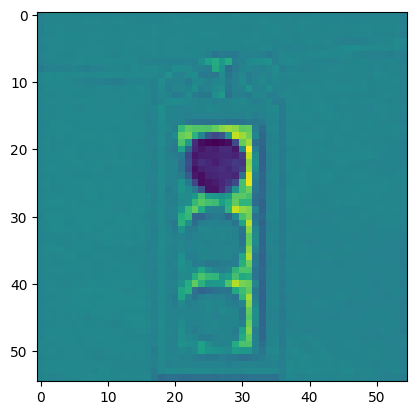

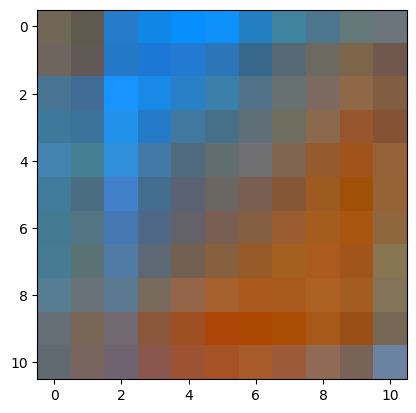

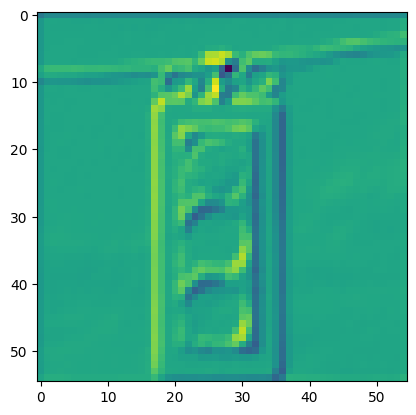

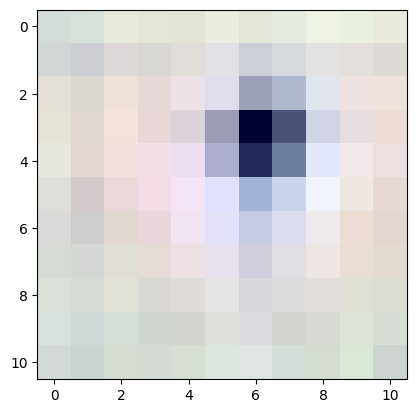

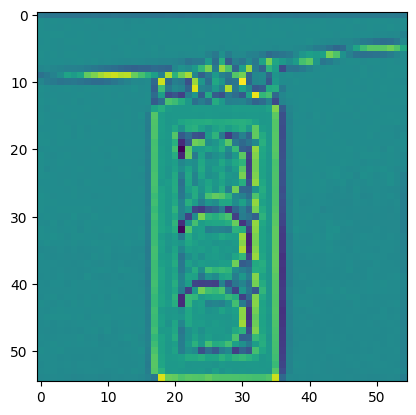

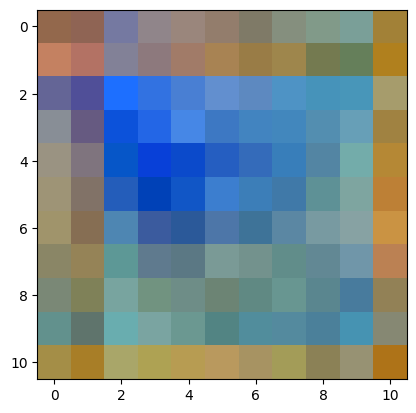

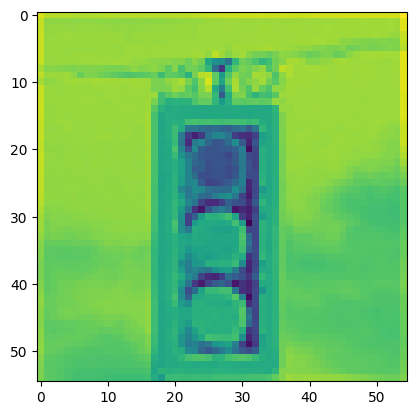

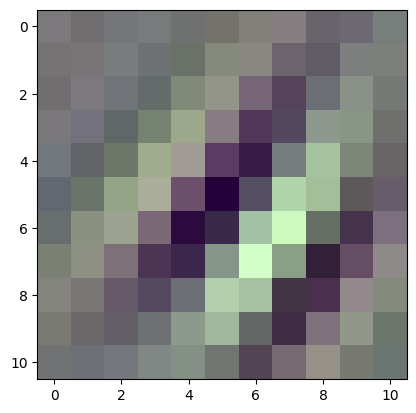

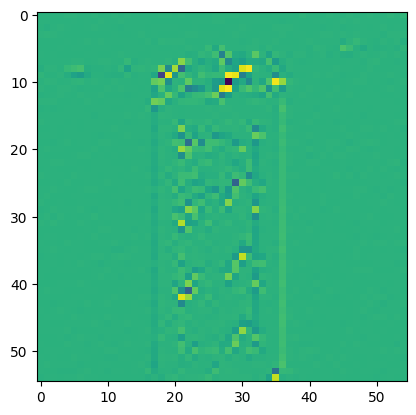

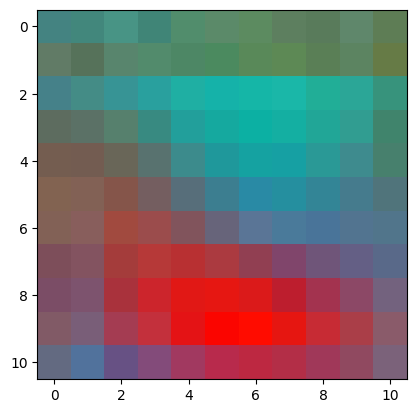

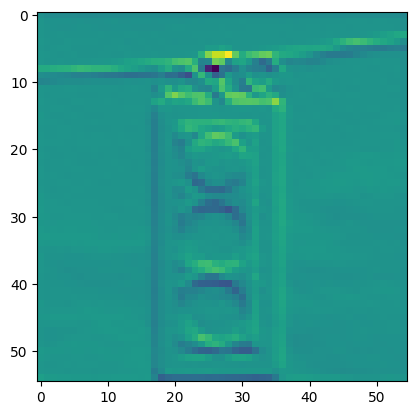

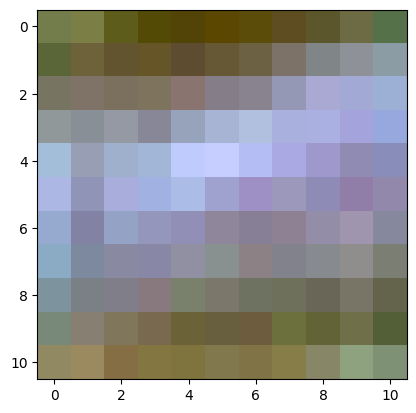

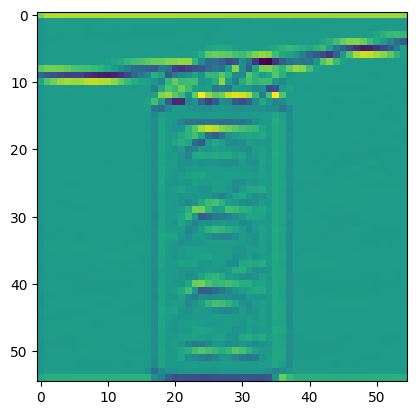

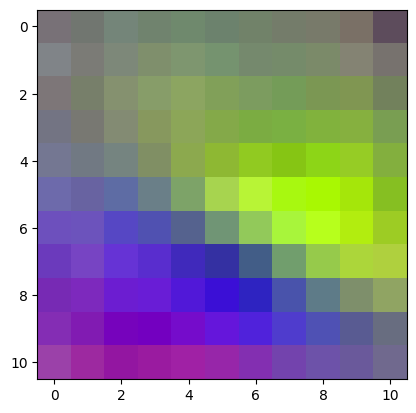

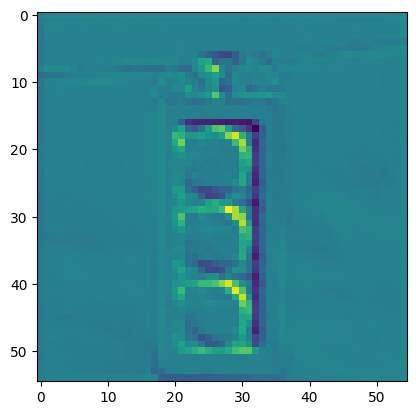

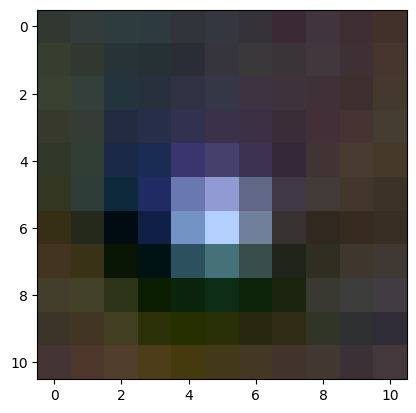

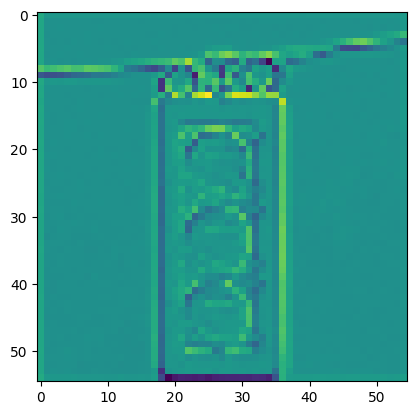

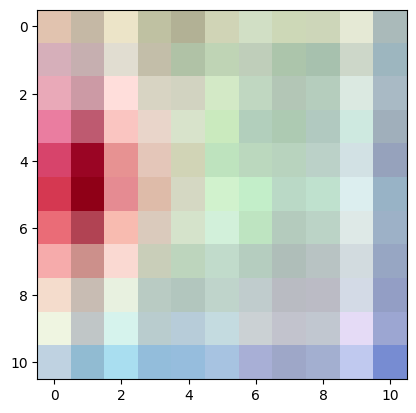

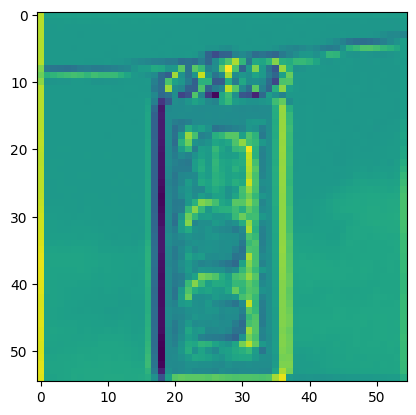

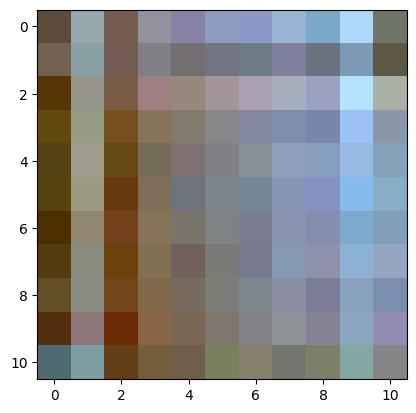

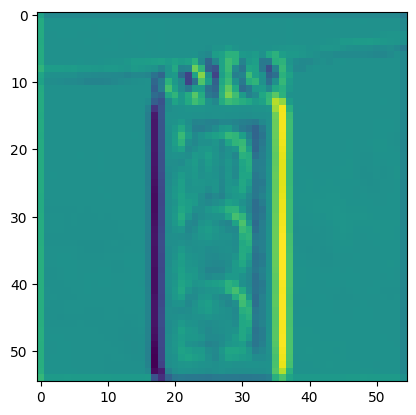

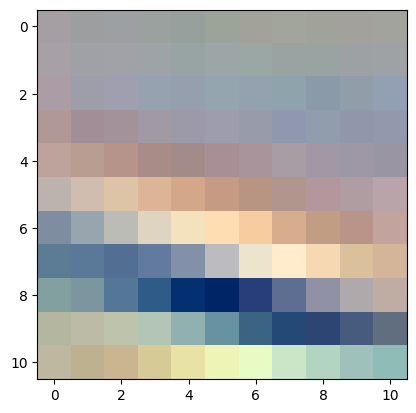

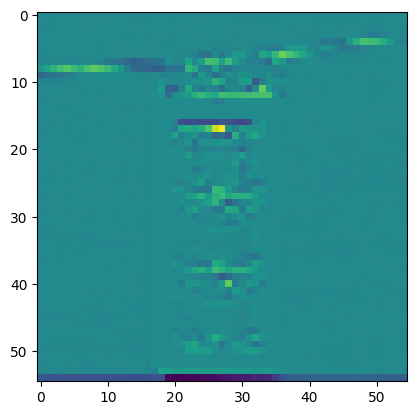

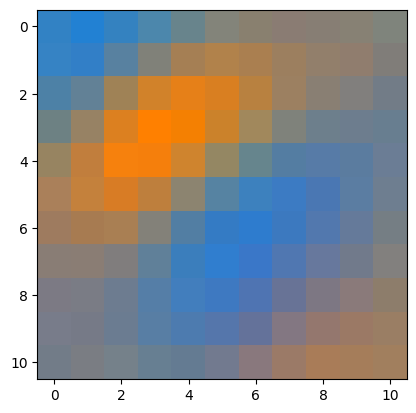

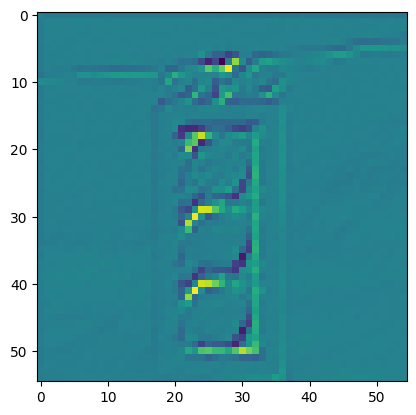

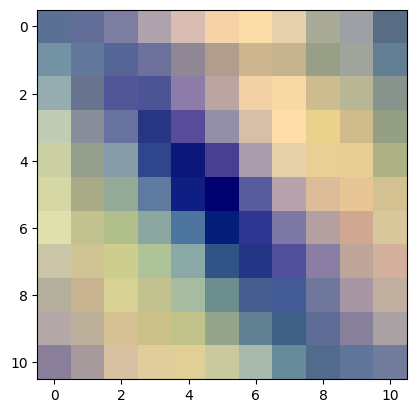

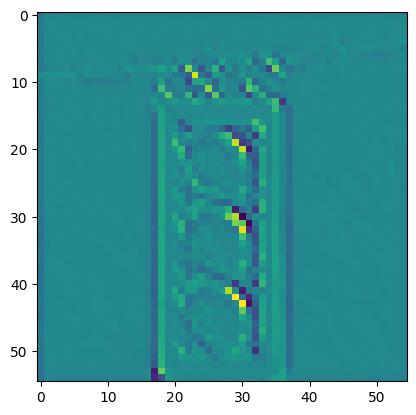

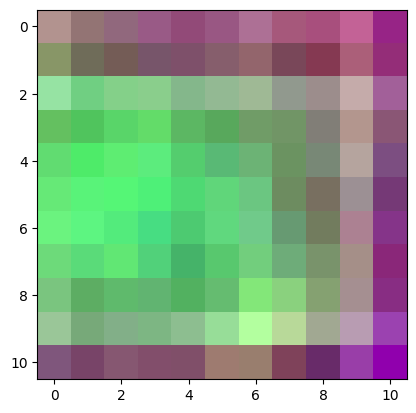

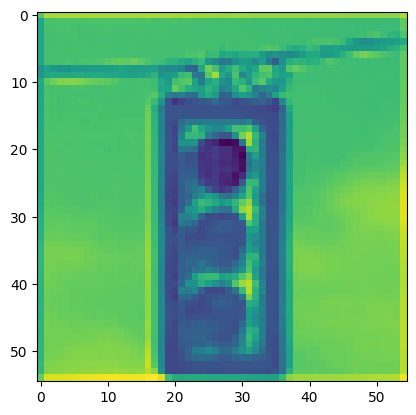

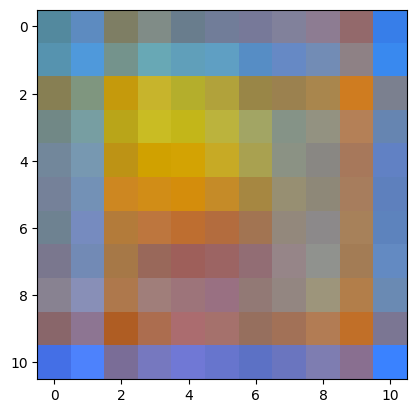

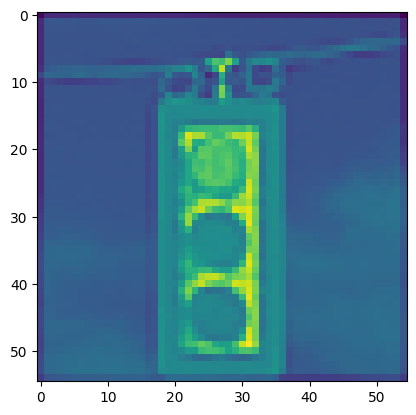

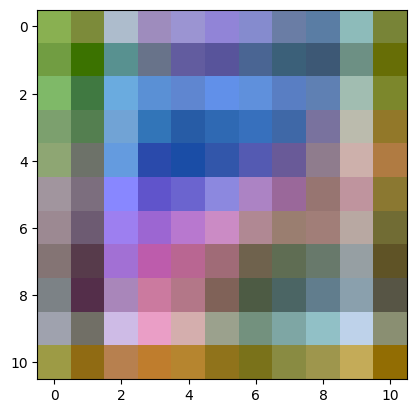

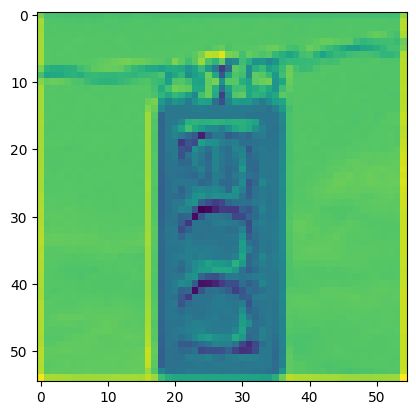

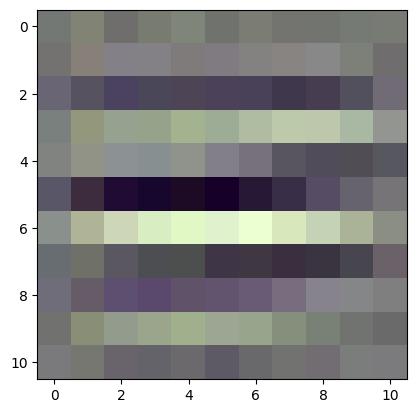

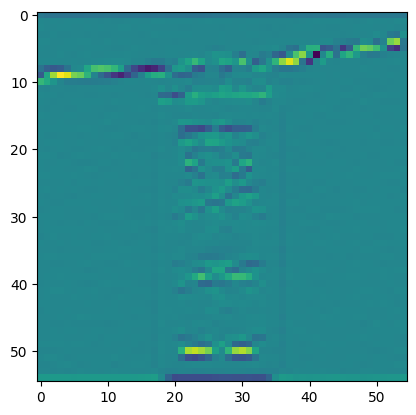

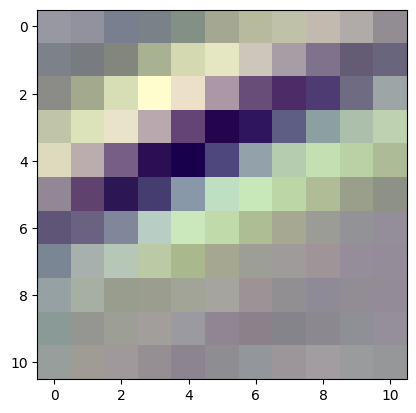

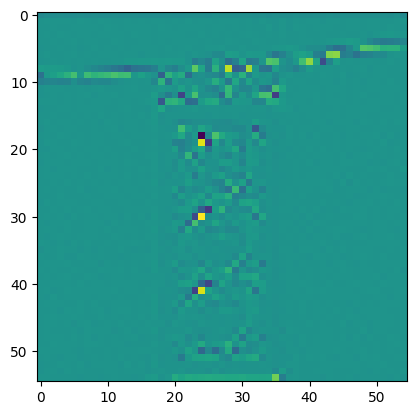

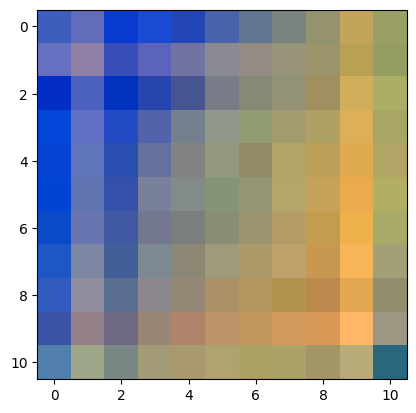

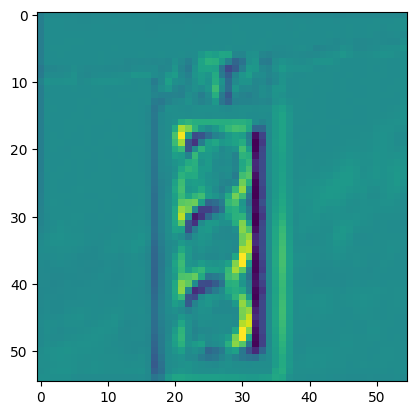

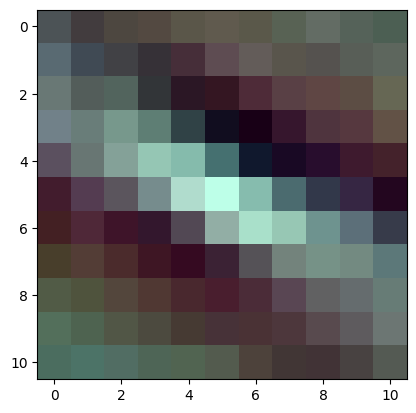

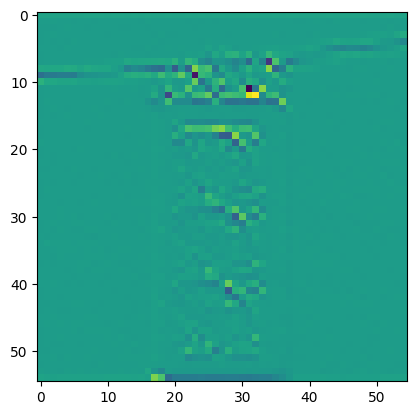

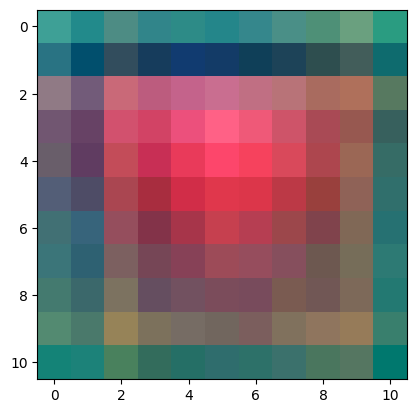

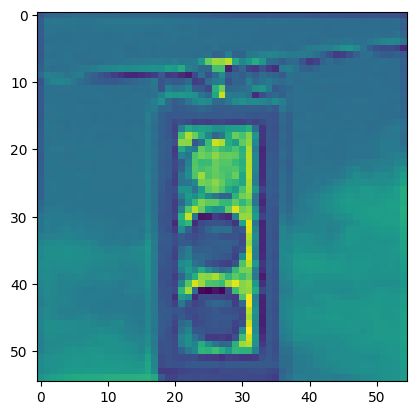

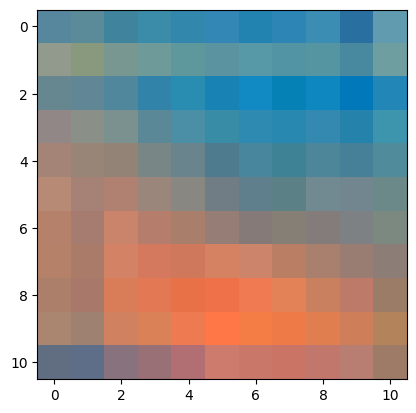

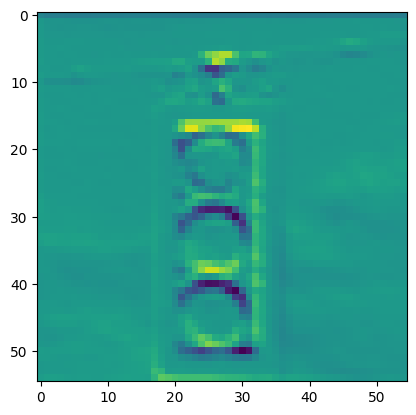

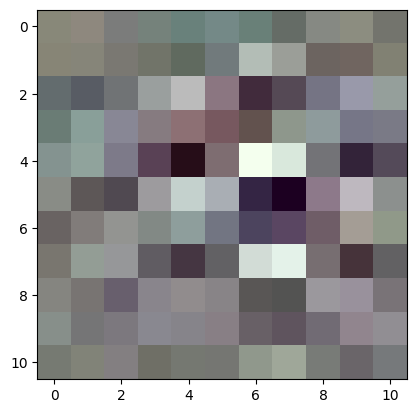

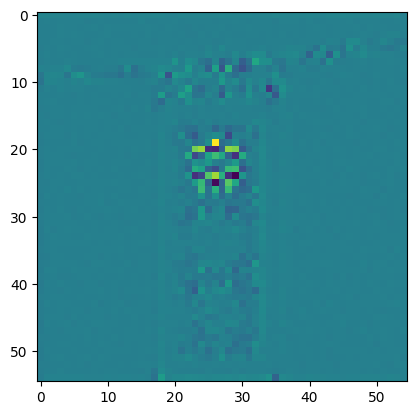

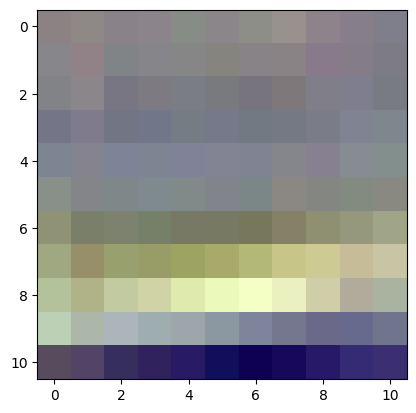

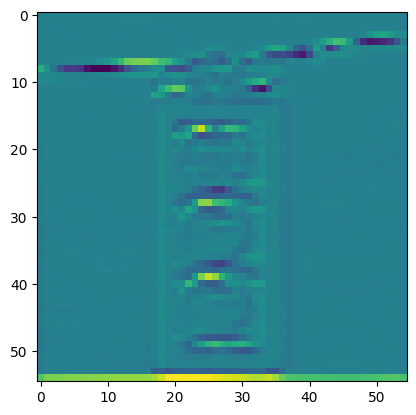

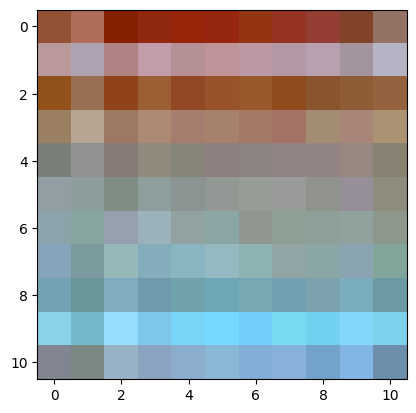

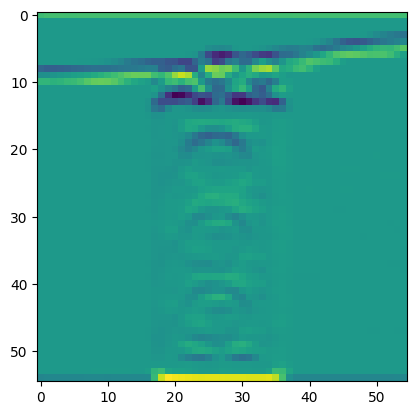

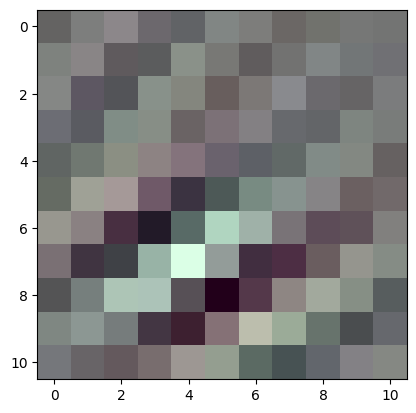

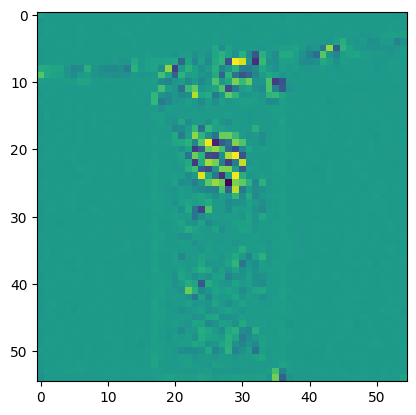

In [22]:
for i in range(64):
    tensor_plot(w0,i)
    plt.imshow(f0[0,i,:,:].cpu().numpy())
    plt.show()

In [23]:
import torch
import matplotlib.pyplot as plt

def plot_feature_maps_with_filters(feature_maps, filters):
    # Remove batch dimension if it exists
    if feature_maps.dim() == 4:
        feature_maps = feature_maps.squeeze(0)

    # Normalize feature maps to [0, 1]
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    def add_filter_to_feature_map(filter_tensor, feature_map_tensor):
        # Ensure the feature map is 2D [H, W]
        if feature_map_tensor.dim() > 2:
            feature_map_tensor = feature_map_tensor.squeeze(0)

        # Convert grayscale feature map to RGB by repeating the single channel 3 times
        feature_map_rgb = feature_map_tensor.unsqueeze(0).repeat((3, 1, 1))

        # Normalize the filter to [0, 1]
        filter_tensor = (filter_tensor - filter_tensor.min()) / (filter_tensor.max() - filter_tensor.min())

        # Ensure the filter fits into the feature map
        min_dim = min(feature_map_tensor.shape)
        filter_size = min(filter_tensor.shape[-1], min_dim)

        # Crop the filter if needed
        filter_cropped = filter_tensor[:, :filter_size, :filter_size]

        # Overlay the RGB filter at the lower-left corner of the feature map
        feature_map_rgb[:, -filter_size:, :filter_size] = filter_cropped

        # Clip the values to be in the range [0, 1]
        feature_map_rgb = torch.clamp(feature_map_rgb, 0, 1)

        return feature_map_rgb

    # Plot montage of feature maps
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))

    for ax, feature_map, filter_ in zip(axes.flat, feature_maps, filters):
        # Add RGB filter to grayscale feature map
        modified_feature_map = add_filter_to_feature_map(filter_, feature_map)

        # Plot modified feature map
        ax.imshow(modified_feature_map.permute(1, 2, 0).cpu().numpy(), interpolation='none')  # Added 'none' interpolation
        ax.axis('off')

    plt.show()



In [24]:
f0.shape,w0.shape

(torch.Size([1, 64, 55, 55]), torch.Size([64, 3, 11, 11]))

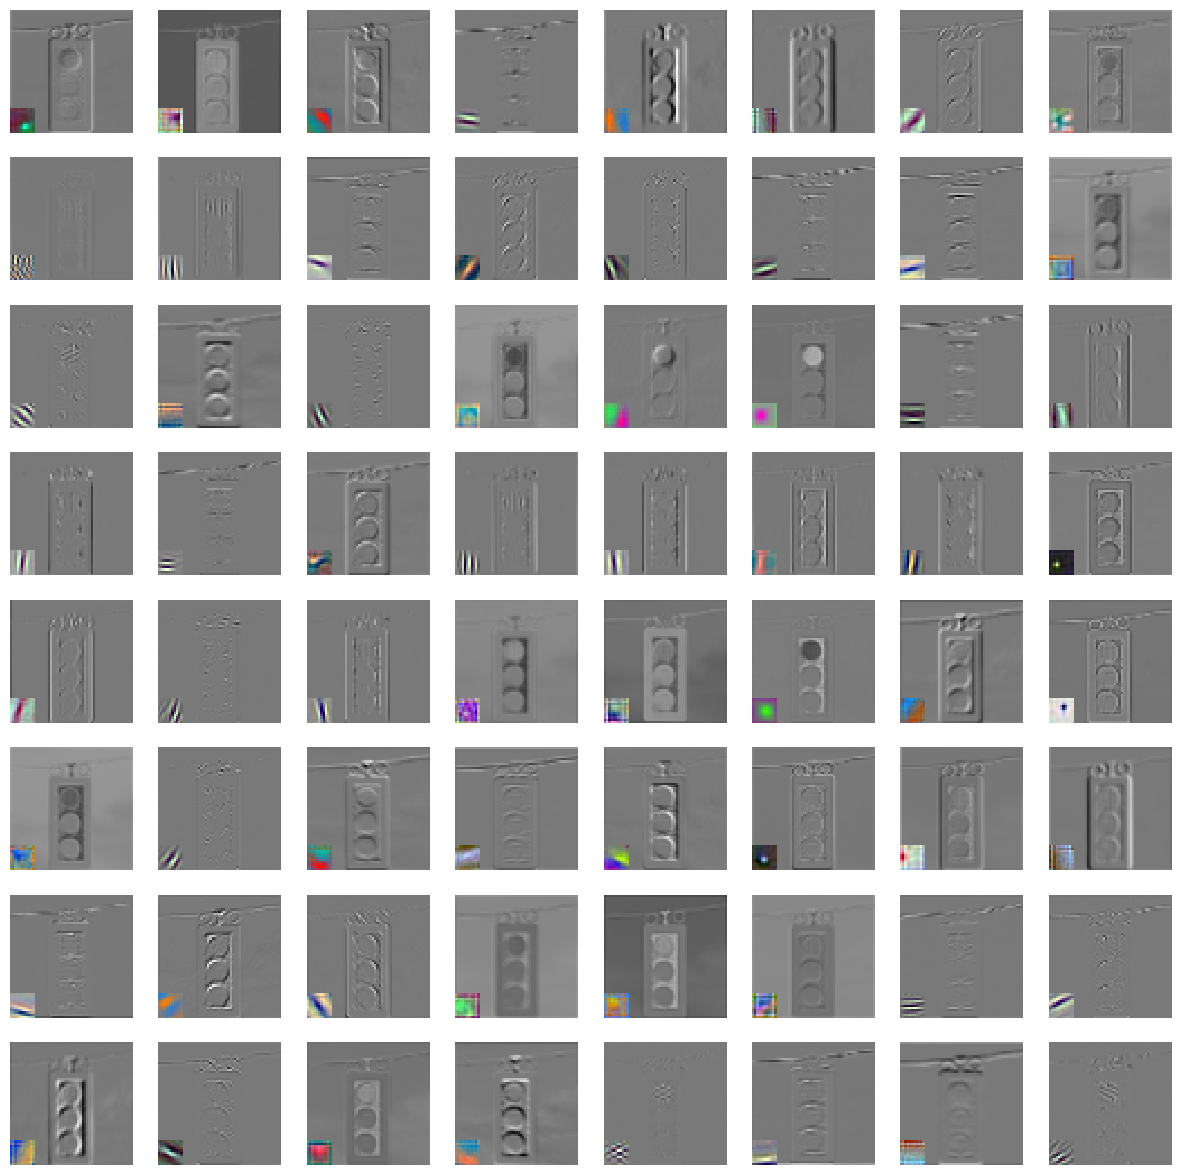

In [25]:
plot_feature_maps_with_filters(f0, w0)

In [26]:
f1 = F.relu(f0)

In [27]:
f1.shape

torch.Size([1, 64, 55, 55])

In [28]:
f2 = F.max_pool2d(f1,kernel_size=3, stride=2, padding=0, dilation=1)

In [29]:
f2.shape

torch.Size([1, 64, 27, 27])

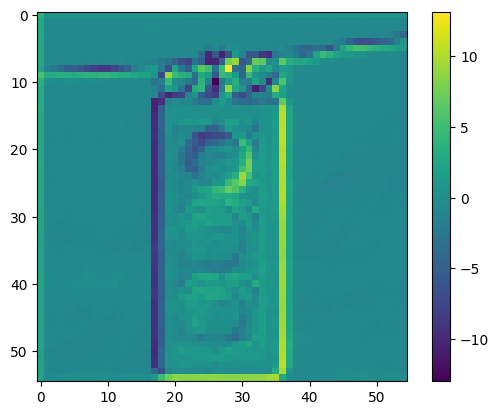

In [30]:
i = 0
plt.imshow(f0[0,i,:,:].cpu().numpy())
plt.colorbar()

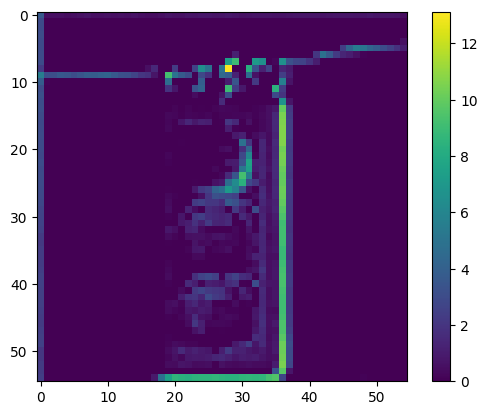

In [31]:
i = 0
plt.imshow(f1[0,i,:,:].cpu().numpy())
plt.colorbar()

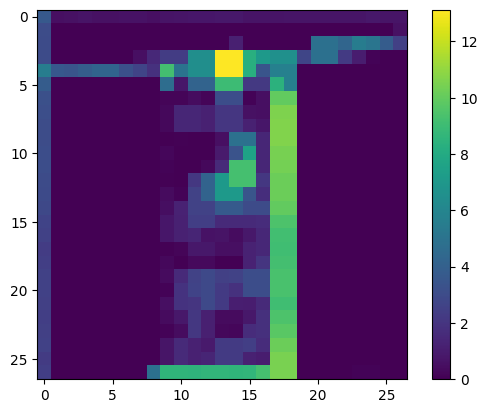

In [32]:
i = 0
plt.imshow(f2[0,i,:,:].cpu().numpy())
plt.colorbar()

In [33]:
f3 = F.conv2d(f2, w1, stride=1, padding=2)

f4 = F.relu(f3)

f5 = F.max_pool2d(f4,kernel_size=3, stride=2, padding=0, dilation=1)

f6 = F.conv2d(f5, w2, stride=1, padding=1)

f7 = F.relu(f6)

f8 = F.conv2d(f7, w3, stride=1, padding=1)

f9 = F.relu(f8)

f10 = F.conv2d(f9, w4, stride=1, padding=1)

f11 = F.relu(f10)

f12 = F.max_pool2d(f11, kernel_size=3, stride=2, padding=0, dilation=1)

f13 = F.adaptive_avg_pool2d(f12,output_size=6).flatten()

f14 = F.linear(f13,w5)

f15 = F.relu(f14)

f16 = F.linear(f15,w6)

f17 = F.relu(f16)

f18 = F.linear(f17,w7)

out = f18.argmax().item()

In [34]:
f18.shape

torch.Size([1000])

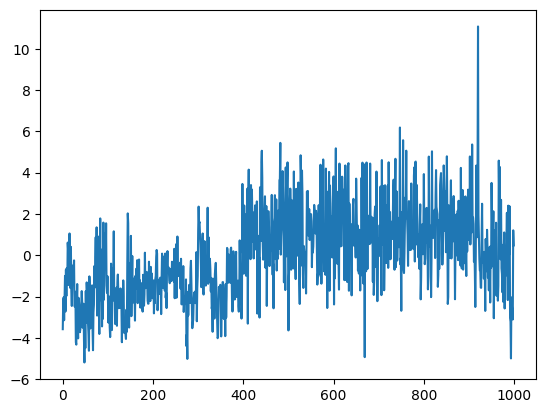

In [35]:
plt.plot(f18.cpu().numpy())

In [36]:
out

920

In [37]:
labels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [38]:
labels[out]

'traffic light, traffic signal, stoplight'

In [39]:
f18.argmax()

tensor(920)

In [40]:
labels[522]

'croquet ball'